In [1]:
from dask.distributed import Client, LocalCluster
# from dask_jobqueue import SLURMCluster

# # cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='118GB', interface='ib0'
#                       ) 
# cluster.scale(120)
# # # cluster.adapt(minimum=1, maximum=48)

# client = Client(cluster)
client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


<Client: 'tcp://127.0.0.1:37946' processes=8 threads=56, memory=270.19 GB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
from scipy.optimize import minimize
from xhistogram.xarray import histogram as xhist
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [4]:
g = 9.81
# alpha = 4e-5
# beta = 7.9e-4
# Ce = 0.01
ncoars = 5
rho0 = 1e3
Cp = 4e3
ys,ye = (2000,2500)
xs,xe = (2300,3100)
zchunk = 15

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc'), 
                         chunks={'z':zchunk}).isel(t=0)
At = (dsmask.e1t * dsmask.e2t).sel(y=slice(ys,ye),x=slice(xs,xe))
Atb = At.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum()
Atb

<xarray.DataArray (y: 100, x: 160)>
dask.array<sum-aggregate, shape=(100, 160), dtype=float64, chunksize=(100, 160), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

In [ ]:
wsbsb_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/wsbs_bar_2009*.nc'), 
                              concat_dim='time_counter', combine='by_coords'
                             ).__xarray_dataarray_variable__
wsbsb_bar = xr.concat([wsbsb_bar.drop('time_centered'), 
                       xr.open_mfdataset(op.join(scratch,'GulfStream/wsbs_bar-*.nc')
                                        ).__xarray_dataarray_variable__.drop('time_centered')],
                      'time_counter')
BFK_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/BFK_bar_2009*.nc'), 
                            concat_dim='time_counter', 
                            combine='by_coords'
                           ).__xarray_dataarray_variable__
BFK_bar = xr.concat([BFK_bar.drop('time_centered'), 
                     xr.open_mfdataset(op.join(scratch,'GulfStream/BFK_bar-*.nc')).__xarray_dataarray_variable__],
                    'time_counter')
wsbs_2010 = xr.open_mfdataset(op.join(scratch,'GulfStream/wsbsXL_bar-*.nc')).__xarray_dataarray_variable__.drop('time_centered')
BFK_2010 = xr.open_mfdataset(op.join(scratch,'GulfStream/BFKXL_bar-*.nc')).__xarray_dataarray_variable__
wsTsb_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/wsTs_bar-*.nc')).__xarray_dataarray_variable__.drop('time_centered')
wsSsb_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/wsSs_bar-*.nc')).__xarray_dataarray_variable__.drop('time_centered')
BFKt_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/BFKt_bar-*.nc')).__xarray_dataarray_variable__
BFKs_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/BFKs_bar-*.nc')).__xarray_dataarray_variable__
# ds = xr.open_mfdataset(op.join(scratch,'GulfStream/BFKt-s_bar-*.nc'))
# BFKt_bar = ds.BFKt
# BFKs_bar = ds.BFKs
# ds = xr.open_mfdataset(op.join(scratch,'GulfStream/Omd_t-s_bar-*.nc'))
# Omdt_bar = ds.Tflux
# Omds_bar = ds.Sflux
# tx_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/tx_bar-*.nc')).__xarray_dataarray_variable__
# sx_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/sx_bar-*.nc')).__xarray_dataarray_variable__
# ty_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/ty_bar-*.nc')).__xarray_dataarray_variable__
# sy_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/sy_bar-*.nc')).__xarray_dataarray_variable__
print(BFK_bar.time_counter, wsbsb_bar.time_counter)
# wsbsb_bar

In [6]:
xr.open_dataset(op.join(scratch,
                        'GulfStream/BachmesoML_bar_Ncoars05-24h_2010-01-01_01-01.nc'))

<xarray.Dataset>
Dimensions:        (depthv: 95, x: 160, y: 100)
Coordinates:
    time_counter   datetime64[ns] ...
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  datetime64[ns] ...
  * depthv         (depthv) float32 0.48045477 1.5587916 ... 790.18054 805.7605
Dimensions without coordinates: x, y
Data variables:
    Bach           (y, x, depthv) float64 ...

In [5]:
wsbsb_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/wsbsb-bar_ML-24h*.nc'), 
                              concat_dim='time_counter', combine='by_coords'
                             ).wb
# wsbsb_bar = xr.concat([wsbsb_bar.drop('time_centered'), 
#                        xr.open_mfdataset(op.join(scratch,'GulfStream/wsbs_bar-*.nc')
#                                         ).__xarray_dataarray_variable__.drop('time_centered')],
#                       'time_counter')
BFK_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/BFKmesoML_bar_Ncoars05-24h*.nc'), 
                            concat_dim='time_counter', 
                            combine='by_coords'
                           ).BFK
Bach_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/BachmesoML_bar_Ncoars05-24h*.nc'), 
                                  concat_dim='time_counter', 
                                  combine='by_coords'
                                 ).Bach
# BFK_bar = xr.open_dataset(op.join(scratch,'GulfStream/BFKmesoML_bar_Ncoars05-24h*.nc'), 
#                                   concat_dim='time_counter', 
#                                   combine='by_coords'
#                                  ).BFK
# BFK_bar = xr.concat([BFK_bar.drop('time_centered'),
#                      xr.open_mfdataset(op.join(scratch,'GulfStream/BFK_bar-*.nc')).__xarray_dataarray_variable__],
#                     'time_counter')
# wsbs_2010 = xr.open_mfdataset(op.join(scratch,'GulfStream/wsbsXL_bar-*.nc')).__xarray_dataarray_variable__.drop('time_centered')
# BFK_2010 = xr.open_mfdataset(op.join(scratch,'GulfStream/BFKXL_bar-*.nc')).__xarray_dataarray_variable__
wsTsb_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/wsbsb-bar_ML-24h*.nc')).wt
wsSsb_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/wsbsb-bar_ML-24h*.nc')).ws
BFKt_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/BFKmesoML_bar_Ncoars05-24h*.nc')).BFKt
BFKs_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/BFKmesoML_bar_Ncoars05-24h*.nc')).BFKs
Bach_bar

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/ipyker

<xarray.DataArray 'Bach' (time_counter: 150, y: 100, x: 160)>
dask.array<concatenate, shape=(150, 100, 160), dtype=float64, chunksize=(25, 100, 160), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(100, 160), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(100, 160), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T23:30:00 ... 2010-05-30T23:30:00
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(25,), meta=np.ndarray>
Dimensions without coordinates: y, x

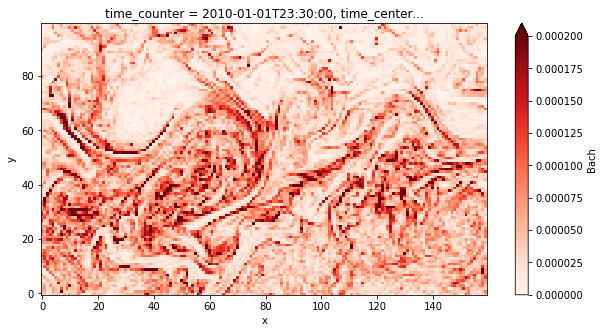

In [8]:
# BFK_bar.where(BFK_bar<1e-6).sel(time_counter='2010-01-01').plot(vmax=6e-10, cmap='Reds')
Bach_bar.isel(time_counter=0).plot(figsize=(10,5), vmin=0., vmax=2e-4, cmap='Reds')

In [54]:
EBF_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/EBF_bar_24h_*.nc')).EBF
EBF_bar

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.DataArray 'EBF' (time_counter: 165, y: 100, x: 160)>
dask.array<concatenate, shape=(165, 100, 160), dtype=float64, chunksize=(25, 100, 160), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(100, 160), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(100, 160), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(15,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-12-17T23:30:00 ... 2010-05-30T23:30:00
Dimensions without coordinates: y, x

In [9]:
MLD_b = xr.open_mfdataset(op.join(scratch,'GulfStream/wsbsb-bar_ML-24h*.nc')).MLD
# qt_bar = xr.open_mfdataset(op.join(scratch,'GulfStream/SurfFlux_bar*.nc')).qt_oce.drop('time_centered')
# so_b = xr.open_mfdataset(op.join(scratch,'GulfStream/SurfFlux_bar*.nc')).sowaflup.drop('time_centered')
Bot_b = xr.open_mfdataset(op.join(scratch,'GulfStream/SurfFlux_bar*.nc')).Bo_tot
Bos_b = xr.open_mfdataset(op.join(scratch,'GulfStream/SurfFlux_bar*.nc')).Bo_sub
alpha_b = xr.open_mfdataset(op.join(scratch,'GulfStream/rho_alpha_betaML_bar-24h*.nc')).alpha
beta_b = xr.open_mfdataset(op.join(scratch,'GulfStream/rho_alpha_betaML_bar-24h*.nc')).beta
# alpha_

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/scratch/cnt0024/hmg2840/tuc

In [10]:
lamML = xr.open_mfdataset(op.join(scratch,'GulfStream/MLradius_Ncoars05-24h*.nc')).lamML
lamML_m = xr.open_mfdataset(op.join(scratch,'GulfStream/MLradius_Ncoars05-24h*.nc')).lamML_m
lamML_b = xr.open_mfdataset(op.join(scratch,'GulfStream/MLradius_Ncoars05-24h*.nc')).lamML_b
boostm = (np.sqrt(Atb.isel(y=slice(1,-1),x=slice(1,-1)))
          * np.maximum(np.maximum(lamML, lamML_m), 1e3)**-1)
boostb = (np.sqrt(Atb.isel(y=slice(1,-1),x=slice(1,-1)))
          * np.maximum(np.maximum(lamML, lamML_b), 1e3)**-1)

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/scratch/cnt0024/hmg2840/tuc

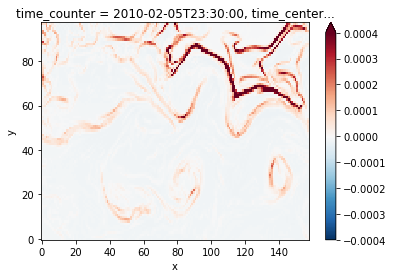

In [10]:
(BFKt_bar + .05*qt_bar.isel(y=slice(1,-1),x=slice(1,-1))*rho0**-1*Cp**-1).sel(time_counter='2010-02-05').plot(vmax=4e-4)

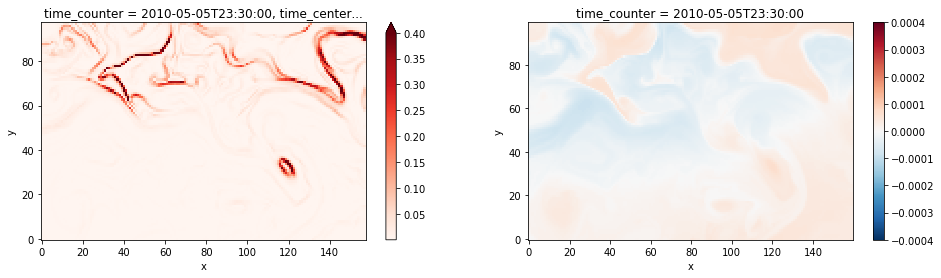

In [20]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
(alpha_b.sel(y=slice(1,-1),x=slice(1,-1))*BFKt_bar).sel(time_counter='2010-05-05').plot(ax=ax1, vmax=4e-1, cmap='Reds')
((qt_bar - ((qt_bar*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
            * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
           ))*rho0**-1*Cp**-1).sel(time_counter='2010-05-05')[-1].plot(ax=ax2, vmin=-4e-4)

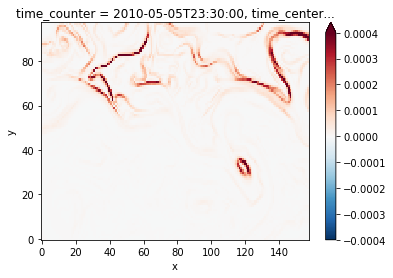

In [21]:
(1e-3*alpha_b.sel(y=slice(1,-1),x=slice(1,-1))*BFKt_bar
 + 1e-2*qt_bar.sel(y=slice(1,-1),x=slice(1,-1))*rho0**-1*Cp**-1).sel(time_counter='2010-05-05').plot(vmax=4e-4)

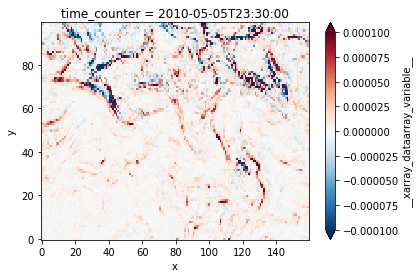

In [24]:
wsTsb_bar.sel(time_counter='2010-05-05').plot(vmax=1e-4)

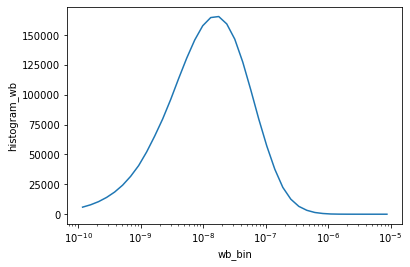

In [10]:
bins = np.logspace(-10, -5, 40)
h = xhist(wsbsb_bar, bins=[bins])
# display(h)
fig, ax = plt.subplots()
h.plot(ax=ax)
ax.set_xscale('log')

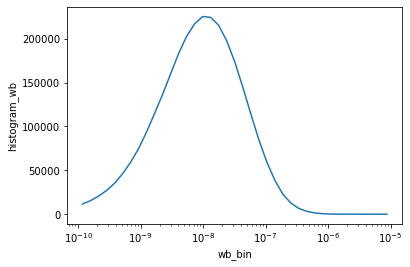

In [12]:
bins = np.logspace(-10, -5, 40)
h = xhist(np.abs(wsbsb_bar), bins=[bins])
# display(h)
fig, ax = plt.subplots()
h.plot(ax=ax)
ax.set_xscale('log')

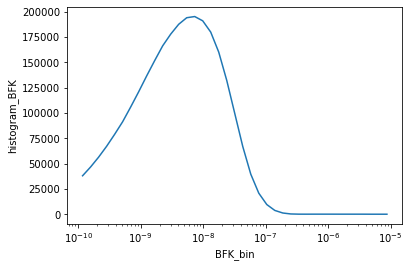

In [44]:
bins = np.logspace(-10, -5, 40)
h = xhist(gradbb2H, bins=[bins])
# display(h)
fig, ax = plt.subplots()
h.plot(ax=ax)
ax.set_xscale('log')

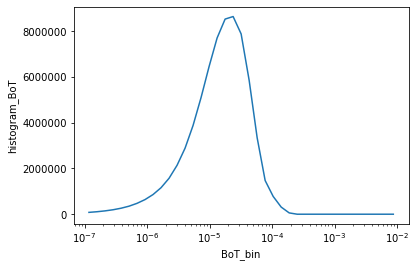

In [22]:
surfB_tot = np.abs(Bot_b)
surfB_tot.name = 'BoT'
bins = np.logspace(-7, -2, 40)
h = xhist(surfB_tot, bins=[bins])
# display(h)
fig, ax = plt.subplots()
h.plot(ax=ax)
ax.set_xscale('log')

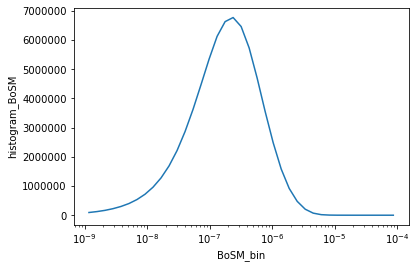

In [26]:
surfB_sub = np.abs(Bos_b)
surfB_sub.name = 'BoSM'
bins = np.logspace(-9, -4, 40)
h = xhist(surfB_sub, bins=[bins])
# display(h)
fig, ax = plt.subplots()
h.plot(ax=ax)
ax.set_xscale('log')

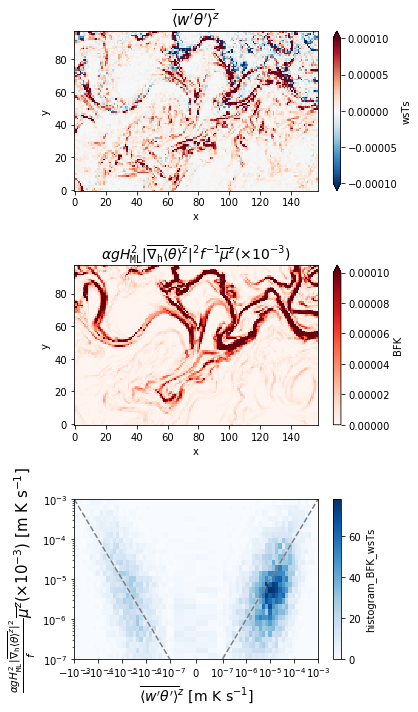

In [25]:
gradtb2H = (alpha_b[:,1:-1,1:-1]*BFKt_bar).sel(time_counter='2010-01-01')
wsTsb_ML = wsTsb_bar.sel(time_counter='2010-01-01')
gradtb2H.name = 'BFK'
wsTsb_ML.name = 'wsTs'


fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,10),nrows=3,ncols=1)
fig.set_tight_layout(True)
# fig = plt.figure(figsize=(14,9))
# # fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsTsb_ML[0,1:-1,1:-1].plot(ax=ax1, vmax=1e-4, cmap='RdBu_r', rasterized=True)
(.001*gradtb2H[0]).plot(ax=ax2, vmin=0., vmax=1e-4, cmap='Reds', rasterized=True)
xhist(.001*gradtb2H[0], 
      wsTsb_ML[0,1:-1,1:-1],
      bins=[np.logspace(-7,-3,30), 
            np.concatenate((-np.logspace(-3,-7,30),
                            np.concatenate((np.linspace(-9e-8,9e-8,5),np.logspace(-7,-3,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-7,1e-3), np.linspace(1e-7,1e-3), c='grey', ls='--')
ax3.plot(np.linspace(-1e-3,-1e-7), np.linspace(1e-3,1e-7), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-7)
ax3.set_yscale('log')
ax3.set_ylim([1e-7,1e-3])
ax3.set_xlim([-1e-3,1e-3])
ax3.set_xlabel(r"$\overline{\langle w'\theta'\rangle}^{z}$ [m K s$^{-1}$]", fontsize=14)
ax2.set_title(r"$\alpha g H_{\tt ML}^2|\overline{\nabla_{\tt h}\langle \theta\rangle}^z|^2 f^{-1} \overline{\mu}^z$"
              + r"($\times 10^{-3}$)", 
              fontsize=14)
ax1.set_title(r"$\overline{\langle w'\theta'\rangle}^{z}$", fontsize=15)
ax3.set_ylabel(r"$\frac{\alpha g H_{\tt ML}^2|\overline{\nabla_{\tt h}\langle \theta\rangle}^z|^2}{f} \overline{\mu}^z$"
               + r"($\times 10^{-3}$) [m K s$^{-1}$]", 
               fontsize=15)
# fig.suptitle(r"Jan. 1, 2010", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsTs_Jan-01-2009_GulfStreamPatch.pdf')

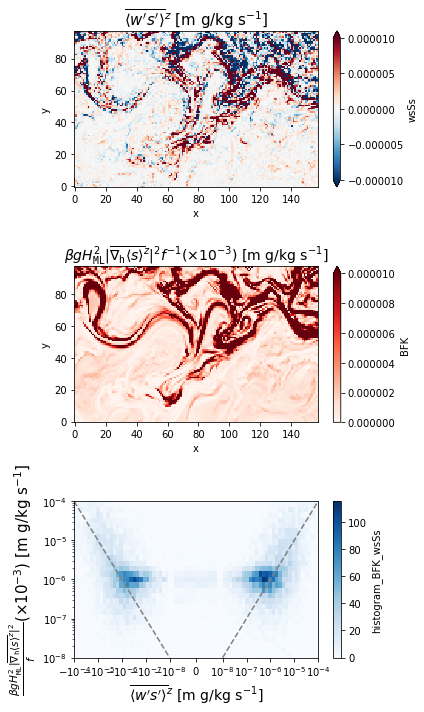

In [33]:
gradsb2H = (beta_b[:,1:-1,1:-1]*BFKs_bar).sel(time_counter='2010-01-01')
wsSsb_ML = wsSsb_bar.sel(time_counter='2010-01-01')
gradsb2H.name = 'BFK'
wsSsb_ML.name = 'wsSs'
from matplotlib.gridspec import GridSpec


fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,10),nrows=3,ncols=1)
fig.set_tight_layout(True)
# fig = plt.figure(figsize=(14,9))
# # fig.set_tight_layout(True)
# gs = GridSpec(2,9,figure=fig)
# ax1 = fig.add_subplot(gs[0,:4])
# ax2 = fig.add_subplot(gs[0,5:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsSsb_ML[0,1:-1,1:-1].plot(ax=ax1, vmax=1e-5, cmap='RdBu_r', rasterized=True)
(.001*gradsb2H[0]).plot(ax=ax2, vmin=0., vmax=1e-5, cmap='Reds', rasterized=True)
xhist(.001*gradsb2H[0], 
      wsSsb_ML[0,1:-1,1:-1],
      bins=[np.logspace(-8,-4,30), 
            np.concatenate((-np.logspace(-4,-8,30),
                            np.concatenate((np.linspace(-9e-9,9e-9,5),np.logspace(-8,-4,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-8,1e-4), np.linspace(1e-8,1e-4), c='grey', ls='--')
ax3.plot(np.linspace(-1e-4,-1e-8), np.linspace(1e-4,1e-8), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-8)
ax3.set_yscale('log')
ax3.set_ylim([1e-8,1e-4])
ax3.set_xlim([-1e-4,1e-4])
ax3.set_xlabel(r"$\overline{\langle w's'\rangle}^{z}$ [m g/kg s$^{-1}$]", fontsize=14)
ax2.set_title(r"$\beta g H_{\tt ML}^2|\overline{\nabla_{\tt h}\langle s\rangle}^z|^2 f^{-1}$"
               + r"($\times 10^{-3}$) [m g/kg s$^{-1}$]", 
               fontsize=14)
ax1.set_title(r"$\overline{\langle w's'\rangle}^{z}$ [m g/kg s$^{-1}$]", fontsize=15)
ax3.set_ylabel(r"$\frac{\beta g H_{\tt ML}^2|\overline{\nabla_{\tt h}\langle s\rangle}^z|^2}{f}$"
              + r"($\times 10^{-3}$) [m g/kg s$^{-1}$]", 
             fontsize=15)
# fig.suptitle(r"Jan. 1, 2010", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsSs_Jan-01-2009_GulfStreamPatch.pdf')

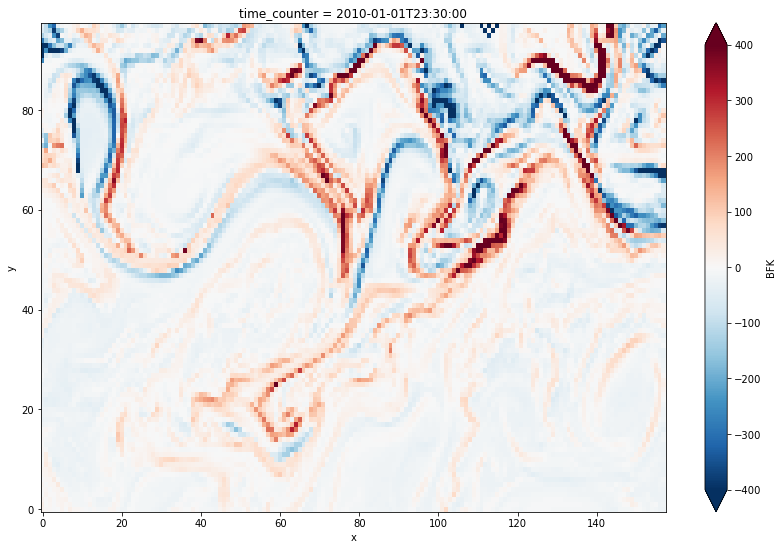

In [89]:
(gradtb2H - gradtb2H[0].mean()/gradsb2H[0].mean()*gradsb2H)[0].plot(figsize=(14,9), cmap='RdBu_r', vmax=400, vmin=-400)

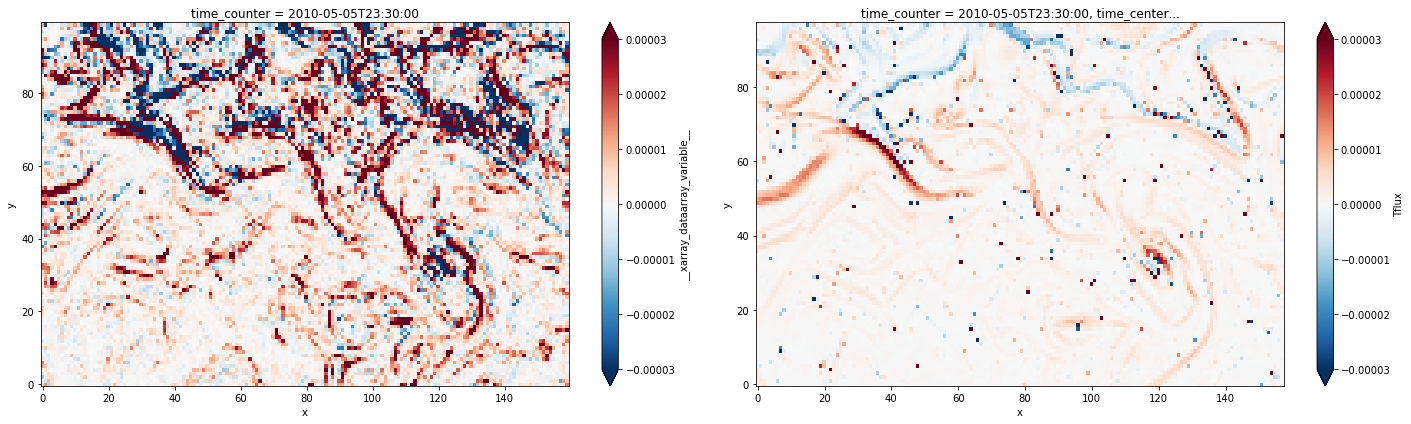

In [5]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
fig.set_tight_layout(True)
wsTsb_bar.sel(time_counter='2010-05-05').plot(ax=ax1, vmin=-3e-5, vmax=3e-5, cmap='RdBu_r')
(Omdt_bar[-1]).plot(ax=ax2, vmax=3e-5, vmin=-3e-5, cmap='RdBu_r')

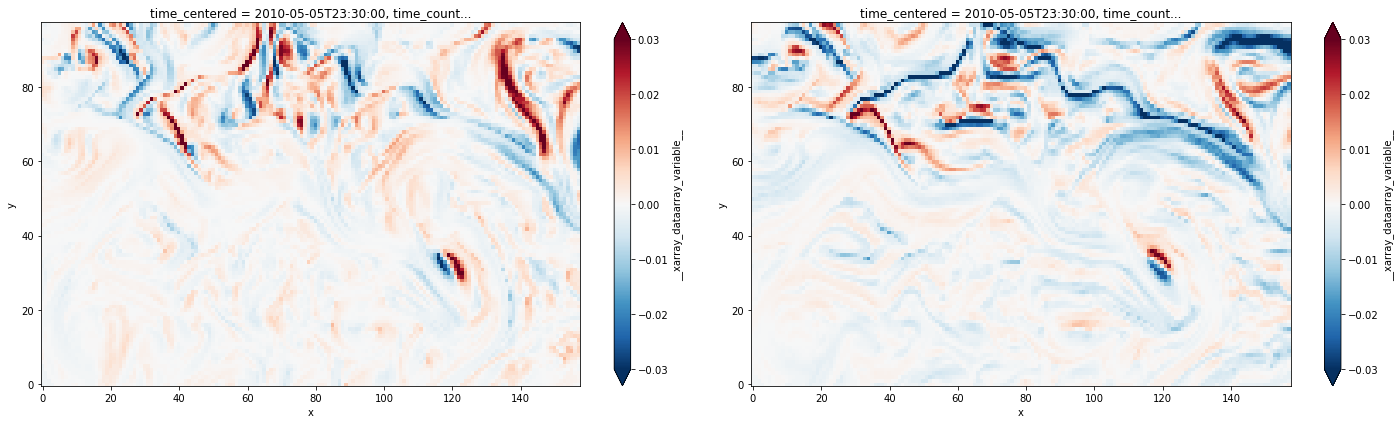

In [124]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
fig.set_tight_layout(True)
(1e-3*alpha*tx_bar[-1]).plot(ax=ax1, vmin=-3e-2, vmax=3e-2, cmap='RdBu_r')
(1e-3*alpha*ty_bar[-1]).plot(ax=ax2, vmax=3e-2, vmin=-3e-2, cmap='RdBu_r')

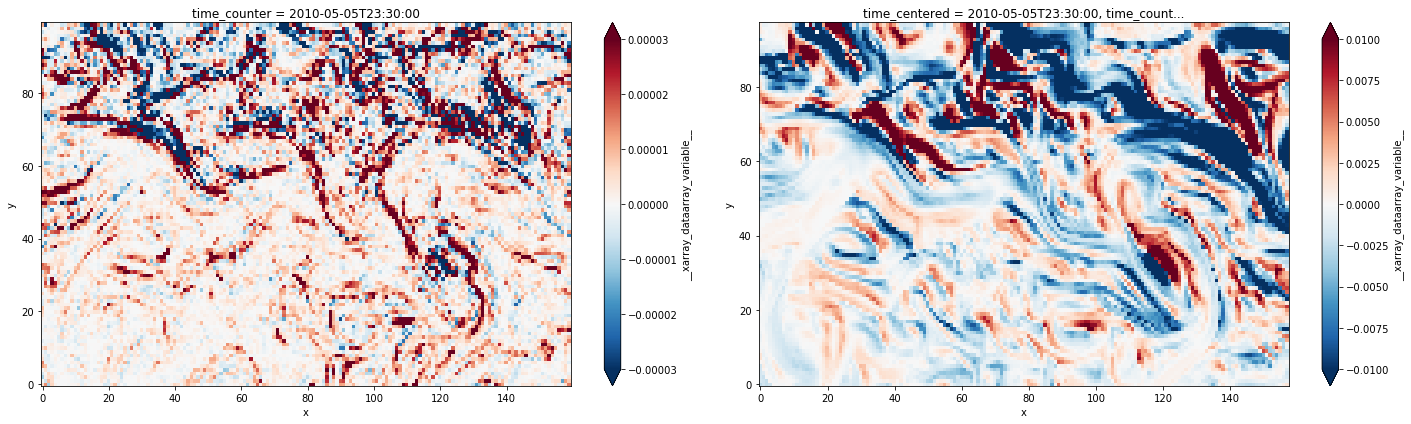

In [135]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
fig.set_tight_layout(True)
wsTsb_bar[-1].plot(ax=ax1, vmin=-3e-5, vmax=3e-5, cmap='RdBu_r')
(1e-3*alpha*(tx_bar+ty_bar)[-1]).plot(ax=ax2, vmin=-1e-2, vmax=1e-2, cmap='RdBu_r')

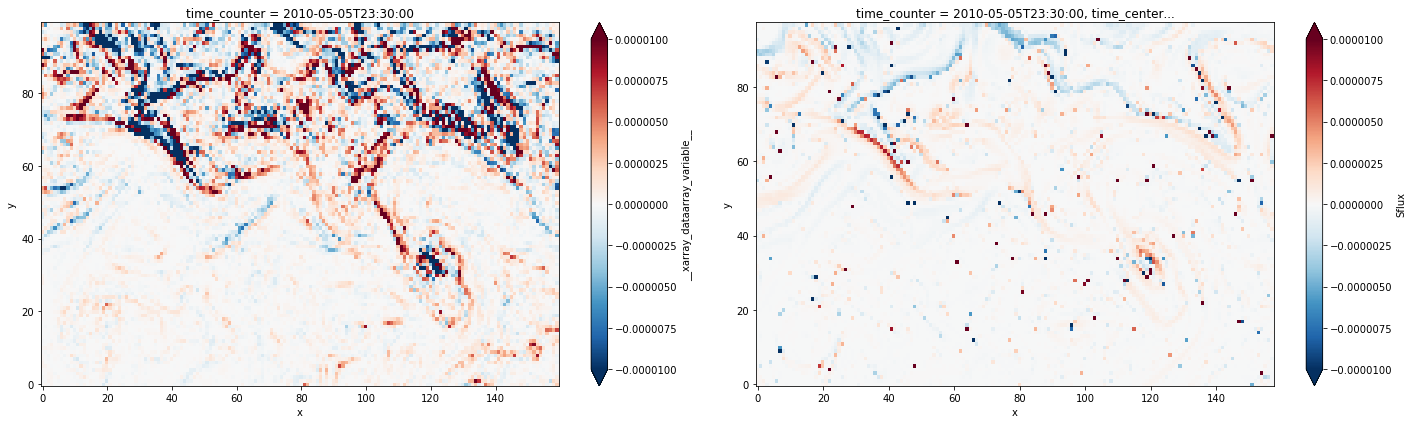

In [7]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
fig.set_tight_layout(True)
wsSsb_bar.sel(time_counter='2010-05-05').plot(ax=ax1, vmin=-1e-5, vmax=1e-5, cmap='RdBu_r')
(Omds_bar[-1]).plot(ax=ax2, vmax=1e-5, vmin=-1e-5, cmap='RdBu_r')

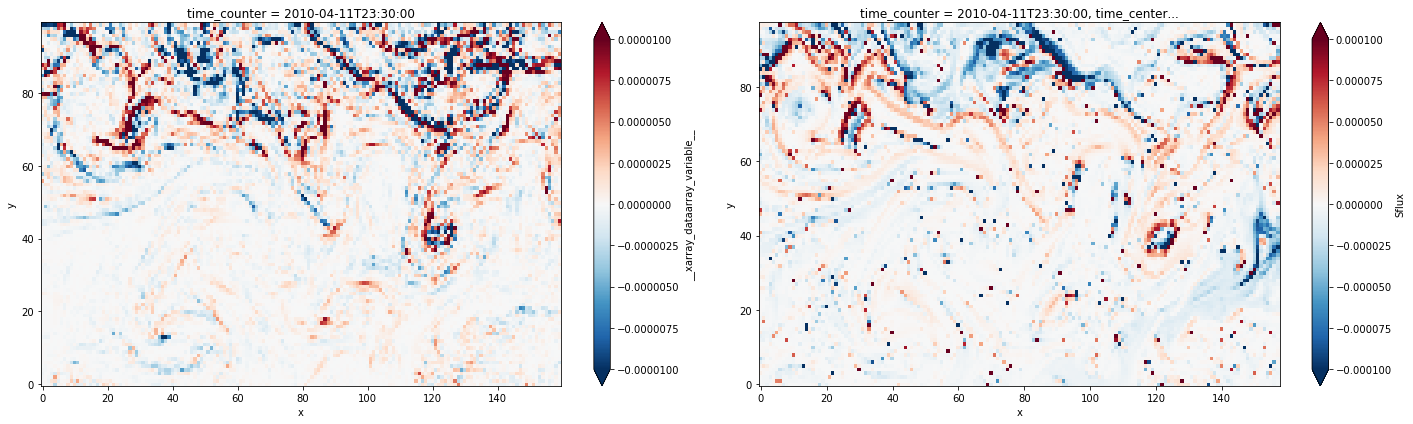

In [11]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
fig.set_tight_layout(True)
wsSsb_bar.sel(time_counter='2010-04-11').plot(ax=ax1, vmin=-1e-5, vmax=1e-5, cmap='RdBu_r')
(Omds_bar.sel(time_counter='2010-04-11')).plot(ax=ax2, vmax=1e-4, vmin=-1e-4, cmap='RdBu_r')

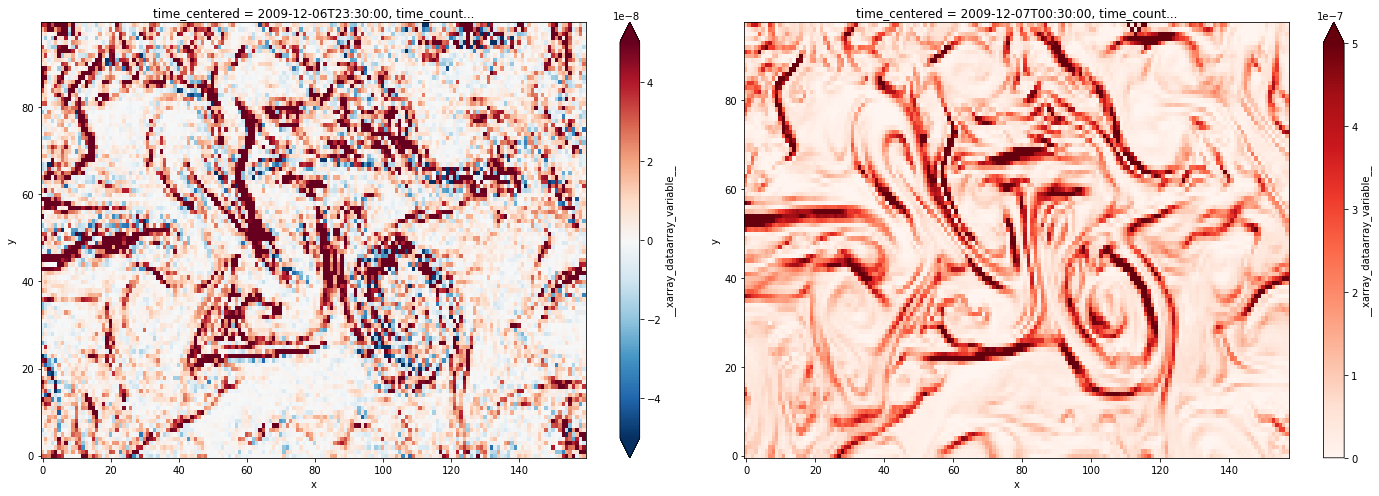

In [5]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
fig.set_tight_layout(True)
wsbsb_bar[-1].plot(ax=ax1, vmin=-5e-8, vmax=5e-8, cmap='RdBu_r')
(BFK_bar[-600]*1e0).plot(ax=ax2, vmin=0, vmax=5e-7, cmap='Reds')

In [36]:
# wsbs = ((wsbsb_bar[:]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
wsbs = ((wsbs_2010[:]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
       )
wsTs = ((wsTsb_bar[:]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
       )
wsSs = ((wsSsb_bar[:]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
       )
# wsTs = wsTsb_bar.load().median(dim=['y','x'])
# wsSs = wsSsb_bar.load().median(dim=['y','x'])
bfk_tot = ((BFK_bar.where(BFK_bar<1e-4)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
           * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
          )
bfk = ((BFK_2010.where(BFK_2010<1e-4)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
       * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
      )
abfkt = ((1e-3*alpha_b.sel(y=slice(1,-1),x=slice(1,-1))*BFKt_bar.where(BFKt_bar<1e3)
          * Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
        )
# bfkt = ((1e-7*BFKt_bar.where(BFKt_bar<1e3)
#          * Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
bbfks = ((1e-3*beta_b.sel(y=slice(1,-1),x=slice(1,-1))*BFKs_bar.where(BFKs_bar<1e3)
          * Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
        )
# omdt = ((Omdt_bar.where(np.abs(Omdt_bar)<1e-2)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# omds = ((Omds_bar.where(np.abs(Omds_bar)<1e-1)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# omdt = Omdt_bar.load().median(dim=['y','x'])
# omds = Omds_bar.load().median(dim=['y','x'])
# omdt
wsbs

<xarray.DataArray (time_counter: 125)>
dask.array<mul, shape=(125,), dtype=float64, chunksize=(25,), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-01-01T23:30:00 ... 2010-05-05T23:30:00

# Let's invert the coefficients to least-square fit the parametrization

$$\overline{w'b'} = c_e \text{BFK} + \delta B_{0_s} + \gamma\text{EBF}$$
$$
\left(\begin{array}{c} 
\vdots \\
\overline{w'b'}^{ji} \\
\vdots
\end{array}\right) 
=
\left(\begin{array}{ccc}
\vdots & \vdots & \vdots \\
\text{BFK}^{ji} & B_{0_s}^{ji} & \text{EBF}^{ji} \\
\vdots & \vdots & \vdots
\end{array}\right)
\cdot 
\left(\begin{array}{c} 
c_e \\
\delta \\
\gamma
\end{array}\right)
$$

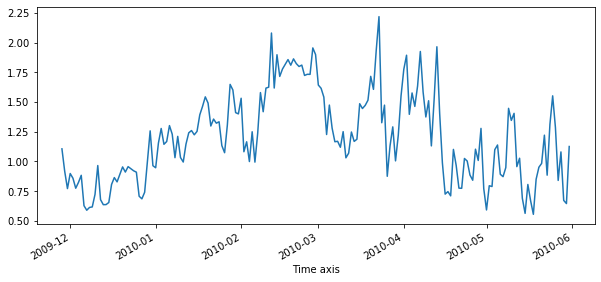

In [34]:
Ce_bfk = (wsbsb_bar.isel(y=slice(1,-1),x=slice(1,-1))
          / (boostm*BFK_bar.where(BFK_bar<1e-6).isel(y=slice(1,-1),x=slice(1,-1)))
         ).load().median(['y','x'],skipna=True)
Ce_bfk.plot(figsize=(10,4))

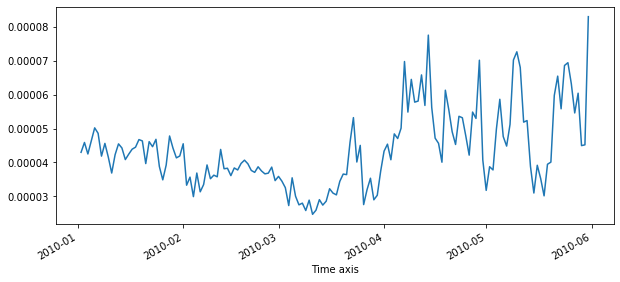

In [35]:
Ce_bachb = (wsbsb_bar.isel(y=slice(1,-1),x=slice(1,-1))
            / (boostm*Bach_bar.where(Bach_bar<1e-2).isel(y=slice(1,-1),x=slice(1,-1)))
           ).load().median(['y','x'],skipna=True)
Ce_bachb.plot(figsize=(10,4))

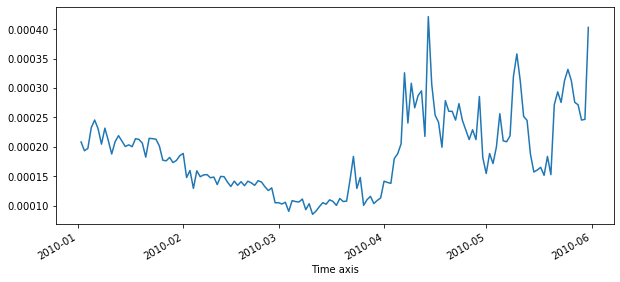

In [36]:
Ce_bach = (wsbsb_bar.isel(y=slice(1,-1),x=slice(1,-1))
           / (Bach_bar.where(Bach_bar<1e-2).isel(y=slice(1,-1),x=slice(1,-1)))
          ).load().median(['y','x'],skipna=True)
Ce_bach.plot(figsize=(10,4))

In [47]:
Ny,Nx = Bach_bar.isel(time_counter=0).shape
wb = wsbsb_bar.sel(time_counter='2010-01-01').isel(y=slice(1,-1),x=slice(1,-1)).values.reshape((int(Ny*Nx),1))
bach = (boost*Bach_bar.where(Bach_bar<1e-2)).sel(time_counter='2010-01-01').values.reshape((int(Ny*Nx),1))
bo = Bos_b[23::24].sel(time_counter='2010-01-01').isel(y=slice(1,-1),x=slice(1,-1)).values.reshape((int(Ny*Nx),1))
rhs = np.append(bfk, bo, axis=1)
print(rhs.shape)
consts = np.dot(np.linalg.pinv(rhs),wb)
consts

ValueError: cannot reshape array of size 15484 into shape (16000,1)

In [56]:
Nt,Ny,Nx = Bach_bar.sel(time_counter=slice('2010-01-01',None)).shape
# consts = xr.DataArray(np.ones((Nt,3))*np.nan, dims=['time_counter','coeffs'],
#                       coords={'time_counter':BFK_bar.time_counter.data})
# cep = xr.DataArray(np.ones(Nt)*np.nan, dims=['time_counter'],
#                    coords={'time_counter':BFK_bar.time_counter.data})

# for tt in wsbsb_bar.time_counter:
#     bfk = np.ma.masked_invalid((boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1), x=slice(1,-1))).sel(time_counter=tt))
#     wb = np.ma.masked_invalid(wsbsb_bar.sel(time_counter=tt).isel(y=slice(1,-1), x=slice(1,-1)))
#     bfk_comp = np.ma.masked_array(bfk, wb.mask).compressed()
#     wb_comp = np.ma.masked_array(wb, bfk.mask).compressed()
    
#     bo = np.ma.masked_array(np.ma.masked_array(Bos_b[23::24].sel(time_counter=tt).isel(y=slice(1,-1),x=slice(1,-1)),
#                                                bfk.mask),
#                             wb.mask).compressed()
#     rhs = np.append(bfk_comp.reshape((len(bfk_comp),1)), bo.reshape((len(bfk_comp),1)), axis=1)
    
#     consts.sel(time_counter=tt)[:] = np.append(np.dot(np.linalg.pinv(rhs),wb_comp), 
#                                                np.dot(np.linalg.pinv(bfk_comp.reshape((len(bfk_comp),1))),
#                                                       wb_comp), 
#                                                axis=0).ravel()
#     cep.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(bfk),wb).ravel()
#     print(tt)
# consts.to_netcdf(op.join(scratch,'GulfStream/Ce-delta_mesoNcoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
#                          % (5,2009,11,27,2010,5,30)), mode='w')


consts_EBF = xr.DataArray(np.ones((Nt,2))*np.nan, dims=['time_counter','coeffs'],
                          coords={'time_counter':Bach_bar.time_counter.sel(time_counter=slice('2010-01-01',
                                                                                             None)).data})
consts_Bo = xr.DataArray(np.ones((Nt,2))*np.nan, dims=['time_counter','coeffs'],
                         coords={'time_counter':Bach_bar.time_counter.sel(time_counter=slice('2010-01-01',
                                                                                            None)).data})
consts_tot = xr.DataArray(np.ones((Nt,3))*np.nan, dims=['time_counter','coeffs'],
                          coords={'time_counter':Bach_bar.time_counter.sel(time_counter=slice('2010-01-01',
                                                                                             None)).data})
# cep = xr.DataArray(np.ones(Nt)*np.nan, dims=['time_counter'],
#                    coords={'time_counter':BFK_bar.time_counter.data})

for tt in wsbsb_bar.time_counter.sel(time_counter=slice('2010-01-01',None)):
    bach = np.ma.masked_invalid((boostm*Bach_bar.where(Bach_bar<1e-2).isel(y=slice(1,-1), x=slice(1,-1))
                                ).sel(time_counter=tt))
    wb = np.ma.masked_invalid(wsbsb_bar.isel(y=slice(1,-1), x=slice(1,-1)).sel(time_counter=tt))
    bach_comp = np.ma.masked_array(bach, wb.mask).compressed()
    wb_comp = np.ma.masked_array(wb, bach.mask).compressed()
    
    bo = np.ma.masked_array(np.ma.masked_array(Bos_b.isel(y=slice(1,-1), x=slice(1,-1)
                                                         ).sel(time_counter=tt),bach.mask),
                            wb.mask).compressed()
    ebf = np.ma.masked_array(np.ma.masked_array(EBF_bar.isel(y=slice(1,-1), x=slice(1,-1)
                                                            ).sel(time_counter=tt),bach.mask),
                             wb.mask).compressed()
    
    
    rhs = np.append(bach_comp.reshape((len(bach_comp),1)), ebf.reshape((len(bach_comp),1)), axis=1)
    consts_EBF.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(rhs),wb_comp).ravel()
    
    
    rhs = np.append(bach_comp.reshape((len(bach_comp),1)), bo.reshape((len(bach_comp),1)), axis=1)
    consts_Bo.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(rhs),wb_comp).ravel()
    
    rhs = np.append(np.append(bach_comp.reshape((len(bach_comp),1)), 
                              bo.reshape((len(bach_comp),1)), axis=1),
                    ebf.reshape((len(bach_comp),1)), axis=1)
    consts_tot.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(rhs),wb_comp).ravel()
#     cep.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(bfk),wb).ravel()
#     print(tt)
consts_tot

<xarray.DataArray (time_counter: 150, coeffs: 3)>
array([[ 1.01358407e-04,  7.26655532e-04, -2.65210695e-02],
       [ 9.49088635e-05, -3.14479203e-03, -5.54161832e-02],
       [ 8.69435194e-05, -2.37373465e-03, -5.63155318e-02],
       [ 9.79047703e-05, -4.07259925e-03, -1.69145864e-02],
       [ 9.44410047e-05, -1.67576346e-03,  3.68634989e-02],
       [ 8.75397018e-05, -1.01286384e-03, -1.70207267e-02],
       [ 8.38723820e-05,  5.56267905e-05, -3.39338094e-02],
       [ 8.46515422e-05,  7.69550427e-04,  3.71915672e-02],
       [ 8.75791001e-05, -3.72376505e-03, -3.98962589e-02],
       [ 7.34119643e-05, -2.70285542e-03, -2.08465053e-03],
       [ 8.57497293e-05, -4.10790608e-03,  9.63240072e-03],
       [ 9.44742335e-05, -2.28992663e-03,  1.57183030e-02],
       [ 9.32138295e-05, -2.45259077e-03,  9.87115175e-04],
       [ 8.70276059e-05,  1.31082831e-03, -7.92003278e-03],
       [ 8.36890767e-05, -3.00738440e-03,  6.06006689e-03],
       [ 8.13253391e-05, -3.09734468e-04, -4.68683817e-02],
       [ 8.52841413e-05, -5.43452983e-03, -1.97896839e-02],
       [ 8.56788441e-05, -4.60673322e-03, -4.44925203e-02],
       [ 9.85479097e-05, -2.25533744e-03, -1.93684533e-02],
       [ 7.40188610e-05,  9.48078879e-04, -5.76664597e-02],
       [ 8.40490641e-05, -4.26762898e-03, -3.09438380e-02],
       [ 7.94859422e-05, -7.79821023e-03, -2.74130176e-02],
       [ 8.98757236e-05, -1.53425277e-03, -1.57607373e-02],
       [ 7.35061732e-05, -3.15717223e-03,  4.27770105e-02],
       [ 6.51250673e-05,  3.04534043e-04,  3.79291702e-02],
       [ 7.39477263e-05, -2.71518385e-03, -9.10225069e-02],
       [ 7.76888710e-05, -3.51703329e-03, -2.12067030e-02],
       [ 7.65045169e-05, -6.31229561e-03, -5.19591863e-02],
       [ 8.03650142e-05, -5.75399659e-03, -2.17674987e-02],
       [ 7.91494702e-05, -5.73142066e-03,  8.03532032e-03],
       [ 8.54490424e-05, -5.77027822e-03, -4.68031865e-02],
       [ 6.83483944e-05, -8.43774513e-03, -4.50752740e-02],
       [ 6.93007407e-05, -6.70507351e-03, -5.41126413e-02],
       [ 5.81717814e-05, -4.53332588e-03, -1.19646384e-02],
       [ 8.10645867e-05, -4.27219539e-03, -1.03727548e-02],
       [ 7.83952412e-05,  3.58824543e-04, -1.76256309e-02],
       [ 7.84823301e-05, -2.44624656e-03,  2.08020770e-04],
       [ 7.92460198e-05, -6.34623719e-03, -8.96121116e-03],
       [ 7.65720278e-05, -6.60808449e-03,  6.68364485e-02],
       [ 7.48240180e-05, -2.89908055e-03,  5.76936279e-02],
       [ 7.11092912e-05, -8.36801255e-03, -6.28340528e-02],
       [ 7.08180119e-05, -6.15362909e-03, -8.22415399e-03],
       [ 6.79847668e-05, -3.30574746e-03,  7.35078116e-03],
       [ 6.83953510e-05, -8.19287285e-03,  9.51203455e-02],
       [ 6.21657363e-05, -8.70998151e-04, -1.81691248e-02],
       [ 6.50362489e-05, -5.92746454e-03,  4.94127415e-03],
       [ 6.32745085e-05, -1.13212491e-03, -6.00207753e-02],
       [ 5.81595619e-05, -2.58918397e-03, -5.29372988e-02],
       [ 5.88749098e-05, -4.75092458e-03, -8.28768063e-02],
       [ 5.94356047e-05, -1.06817498e-03, -4.04274959e-02],
       [ 5.72580113e-05,  2.38984940e-03,  2.63334516e-03],
       [ 5.31803993e-05,  1.22912110e-03, -3.20351549e-02],
       [ 5.86201774e-05, -6.76806512e-04,  2.54469210e-04],
       [ 5.66577612e-05,  5.30416715e-04, -4.46478625e-02],
       [ 5.76839863e-05,  1.42577767e-03, -8.20891713e-02],
       [ 5.84594489e-05,  5.88747645e-03, -5.61239251e-02],
       [ 6.20928807e-05,  3.14420210e-04, -4.83215454e-02],
       [ 5.48474184e-05, -1.23525733e-03,  3.25611165e-03],
       [ 5.16862110e-05, -3.28188200e-05, -7.85239967e-03],
       [ 5.53532065e-05, -7.93691618e-03, -8.83865990e-02],
       [ 4.99081570e-05, -3.74045739e-03, -5.95644017e-02],
       [ 4.63306405e-05,  1.40323039e-03, -9.27547522e-02],
       [ 5.90371069e-05, -3.35944985e-04, -7.56671270e-02],
       [ 5.64603779e-05, -4.11458930e-03, -2.77012101e-02],
       [ 5.15644337e-05, -1.03739732e-02, -3.77280729e-02],
       [ 4.81839085e-05, -7.36500847e-03, -6.41298

In [58]:
dsave = consts_EBF.to_dataset(name='EBF')
dsave['Bo'] = consts_Bo
# dsave['tot'] = consts_tot
dsave.to_netcdf(op.join(scratch,
            'GulfStream/Consts_Bach_EBF-and-Bo_mesoNcoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
                        % (5,2010,1,1,2010,5,30)), mode='w')
dsave = consts_tot.to_dataset(name='tot')
dsave.to_netcdf(op.join(scratch,
                    'GulfStream/Consts_Bach_tot_mesoNcoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
                        % (5,2010,1,1,2010,5,30)), mode='w')

# ds = xr.open_dataset(op.join(scratch,'GulfStream/Consts_EBF-and-Bo_mesoNcoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
#                              % (5,2009,12,17,2010,5,30)))
# consts_EBF = ds.EBF
# consts_Bo = ds.Bo
# ds = xr.open_dataset(op.join(scratch,'GulfStream/Consts_tot_mesoNcoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
#                              % (5,2009,12,17,2010,5,30)))
# consts_tot = ds.tot

In [60]:
# consts.to_netcdf(op.join(scratch,'GulfStream/Ce-delta_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
#                          % (2009,11,27,2010,5,30)))
consts = xr.open_dataset(op.join(scratch,'GulfStream/Ce-delta_mesoNcoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
                                 % (5,2009,11,27,2010,5,30))).__xarray_dataarray_variable__
consts.mean('time_counter')

<xarray.DataArray '__xarray_dataarray_variable__' (coeffs: 3)>
array([ 1.03735476, -0.00589566,  1.03100045])
Dimensions without coordinates: coeffs

In [9]:
Nt,Ny,Nx = BFK_bar.shape
const_abs = xr.DataArray(np.ones((Nt,1))*np.nan, dims=['time_counter','Ce'],
                         coords={'time_counter':BFK_bar.time_counter.data})
# cep = xr.DataArray(np.ones(Nt)*np.nan, dims=['time_counter'],
#                    coords={'time_counter':BFK_bar.time_counter.data})

for tt in wsbsb_bar.time_counter:
    bfk = np.ma.masked_invalid((boost*BFK_bar.where(BFK_bar<1e-8)).sel(time_counter=tt))
    wb = np.ma.masked_invalid(wsbsb_bar.sel(time_counter=tt).isel(y=slice(1,-1), x=slice(1,-1)))
    bfk_comp = np.ma.masked_array(bfk, wb.mask).compressed()
    wb_comp = np.ma.masked_array(wb, bfk.mask).compressed()
    
    const_abs.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(bfk_comp.reshape((len(bfk_comp),1))),
                                               np.abs(wb_comp)).ravel()
#     cep.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(bfk),wb).ravel()
#     print(tt)

In [22]:
Nt,Ny,Nx = BFK_bar.sel(time_counter=slice('2009-12-17',None)).shape
const_pos = xr.DataArray(np.ones((Nt,3))*np.nan, dims=['time_counter','coeffs'],
                         coords={'time_counter':BFK_bar.time_counter.sel(time_counter=slice('2009-12-17',None)).data})
# cep = xr.DataArray(np.ones(Nt)*np.nan, dims=['time_counter'],
#                    coords={'time_counter':BFK_bar.time_counter.data})

for tt in wsbsb_bar.time_counter.sel(time_counter=slice('2009-12-17',None)):
    bfk = np.ma.masked_invalid((boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1), x=slice(1,-1))).sel(time_counter=tt))
    wb = np.ma.masked_invalid(wsbsb_bar.where(wsbsb_bar>0.).sel(time_counter=tt).isel(y=slice(1,-1), x=slice(1,-1)))
    bfk_comp = np.ma.masked_array(bfk, wb.mask).compressed()
    wb_comp = np.ma.masked_array(wb, bfk.mask).compressed()
    tempC = np.dot(np.linalg.pinv(bfk_comp.reshape((len(bfk_comp),1))),
                   wb_comp).ravel()
    
    
    dwb = (wsbsb_bar.sel(time_counter=tt).isel(y=slice(1,-1),x=slice(1,-1)) 
           - tempC*bfk)
    dwb = np.ma.masked_invalid(dwb)
    dwb_comp = dwb.compressed()
    bo = np.ma.masked_array(Bos_b[23::24].sel(time_counter=tt).isel(y=slice(1,-1),x=slice(1,-1)),
                            dwb.mask).compressed()
    ebf = np.ma.masked_array(EBF_bar.isel(y=slice(1,-1), x=slice(1,-1)).sel(time_counter=tt),
                             dwb.mask).compressed()
    tempd = np.dot(np.linalg.pinv(np.append(bo.reshape((len(bo),1)), ebf.reshape((len(ebf),1)), axis=1)),
                   dwb_comp).ravel()
    
    
    const_pos.sel(time_counter=tt)[:] = np.concatenate((tempC,tempd))
    
const_pos.to_netcdf(op.join(scratch,'GulfStream/Ce-delta-gamma_pos_mesoNcoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
                            % (5,2009,11,27,2010,5,30)), mode='w')

In [61]:
const_pos = xr.open_dataset(op.join(scratch,'GulfStream/Ce-delta-gamma_pos_mesoNcoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
                                    % (5,2009,11,27,2010,5,30))).__xarray_dataarray_variable__
const_pos.mean('time_counter')

<xarray.DataArray '__xarray_dataarray_variable__' (coeffs: 3)>
array([ 1.72127056, -0.00610701, -0.02022428])
Dimensions without coordinates: coeffs

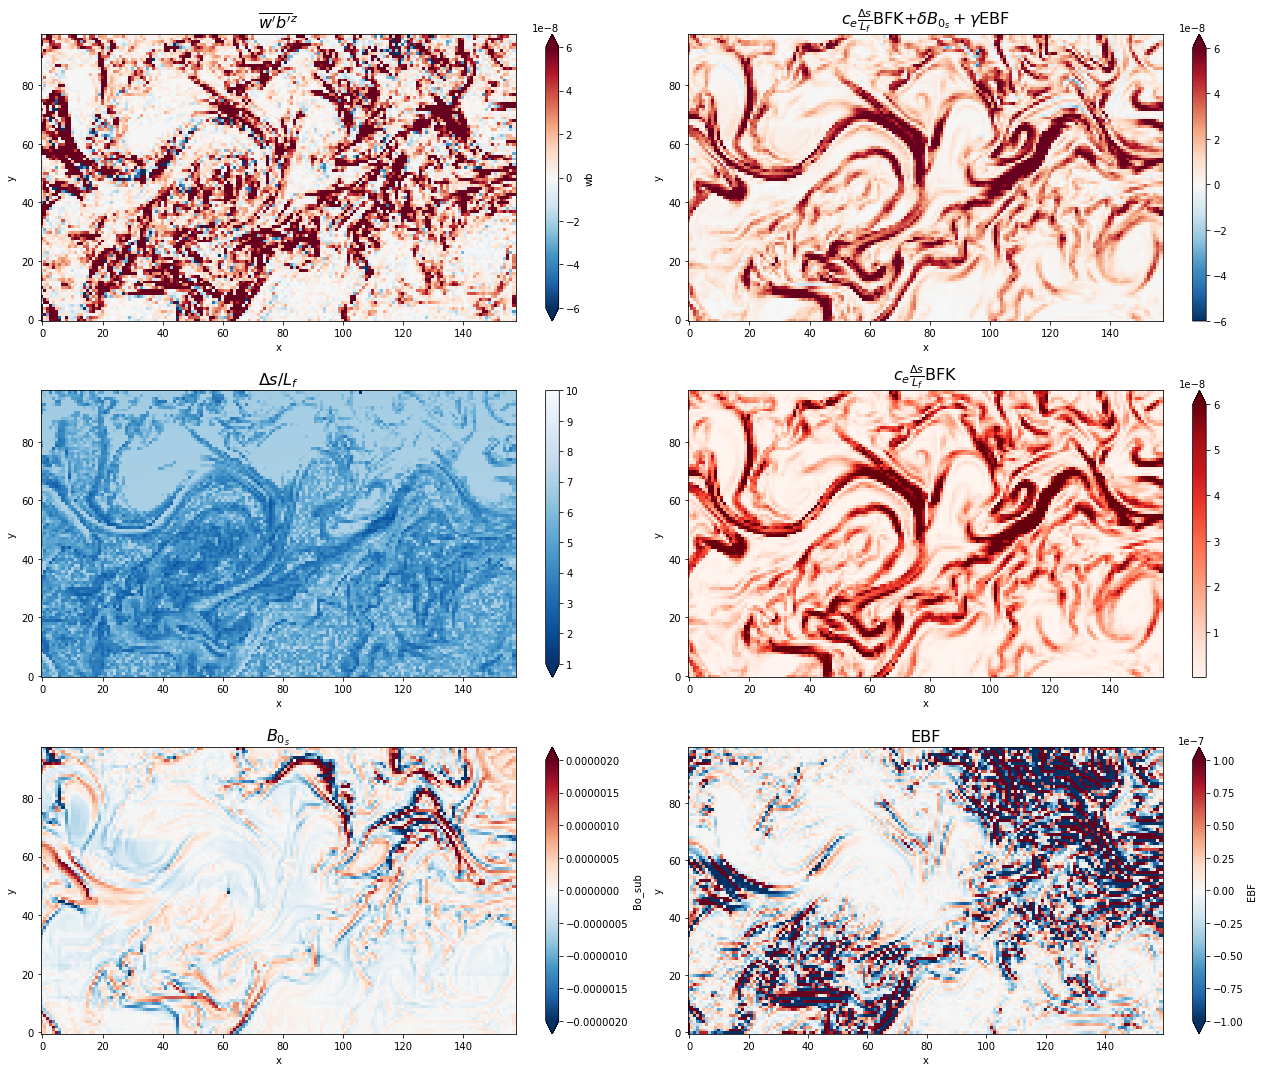

In [28]:
fig, axes = plt.subplots(figsize=(18,15), nrows=3, ncols=2)
fig.set_tight_layout(True)


wsbsb_bar.sel(time_counter='2010-01-01').isel(y=slice(1,-1),
                                              x=slice(1,-1)).plot(ax=axes[0,0], vmax=6e-8, rasterized=True)

(consts_tot[:,0]*boostm
 * BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1),x=slice(1,-1))
).sel(time_counter='2010-01-01').plot(ax=axes[1,1], vmax=6e-8, cmap='Reds', rasterized=True)

# wsbsb_bar.where(wsbsb_bar>0.).sel(time_counter='2010-01-01').plot(ax=axes[0,1], vmax=6e-8, cmap='Reds', rasterized=True)
EBF_bar.sel(time_counter='2010-01-01').plot(ax=axes[2,1], vmax=1e-7, cmap='RdBu_r', rasterized=True)

boostm.sel(time_counter='2010-01-01').plot(ax=axes[1,0], cmap='Blues_r', rasterized=True,
                                           vmin=1.,vmax=1e1)

Bos_b.sel(time_counter='2010-01-01')[-1].isel(y=slice(1,-1),
                                              x=slice(1,-1)).plot(ax=axes[2,0], vmax=2e-6, rasterized=True)
# Bot_b.sel(time_counter='2010-01-01')[-1].isel(y=slice(1,-1),
#                                               x=slice(1,-1)).plot(ax=axes[2,1], vmax=5e-5, rasterized=True)
(consts_tot[:,0]*boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1),x=slice(1,-1))
 + consts_tot[:,1]*Bos_b.isel(y=slice(1,-1),x=slice(1,-1))
 + consts_tot[:,2]*EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))
).sel(time_counter='2010-01-01').plot(ax=axes[0,1], vmax=6e-8, cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"$\overline{w'b'}^z$", fontsize=16)
axes[1,1].set_title(r"$c_e\frac{\Delta s}{L_f}$BFK", fontsize=16)
axes[2,1].set_title(r"EBF", fontsize=16)
axes[1,0].set_title(r"$\Delta s / L_f$", fontsize=16)
axes[2,0].set_title(r"$B_{0_s}$", fontsize=16)
axes[0,1].set_title(r"$c_e\frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s} + \gamma$EBF", fontsize=16)

plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs-meso_EBF-and_Bo_comparison_Jan-01-2010_GulfStreamPatch.pdf')

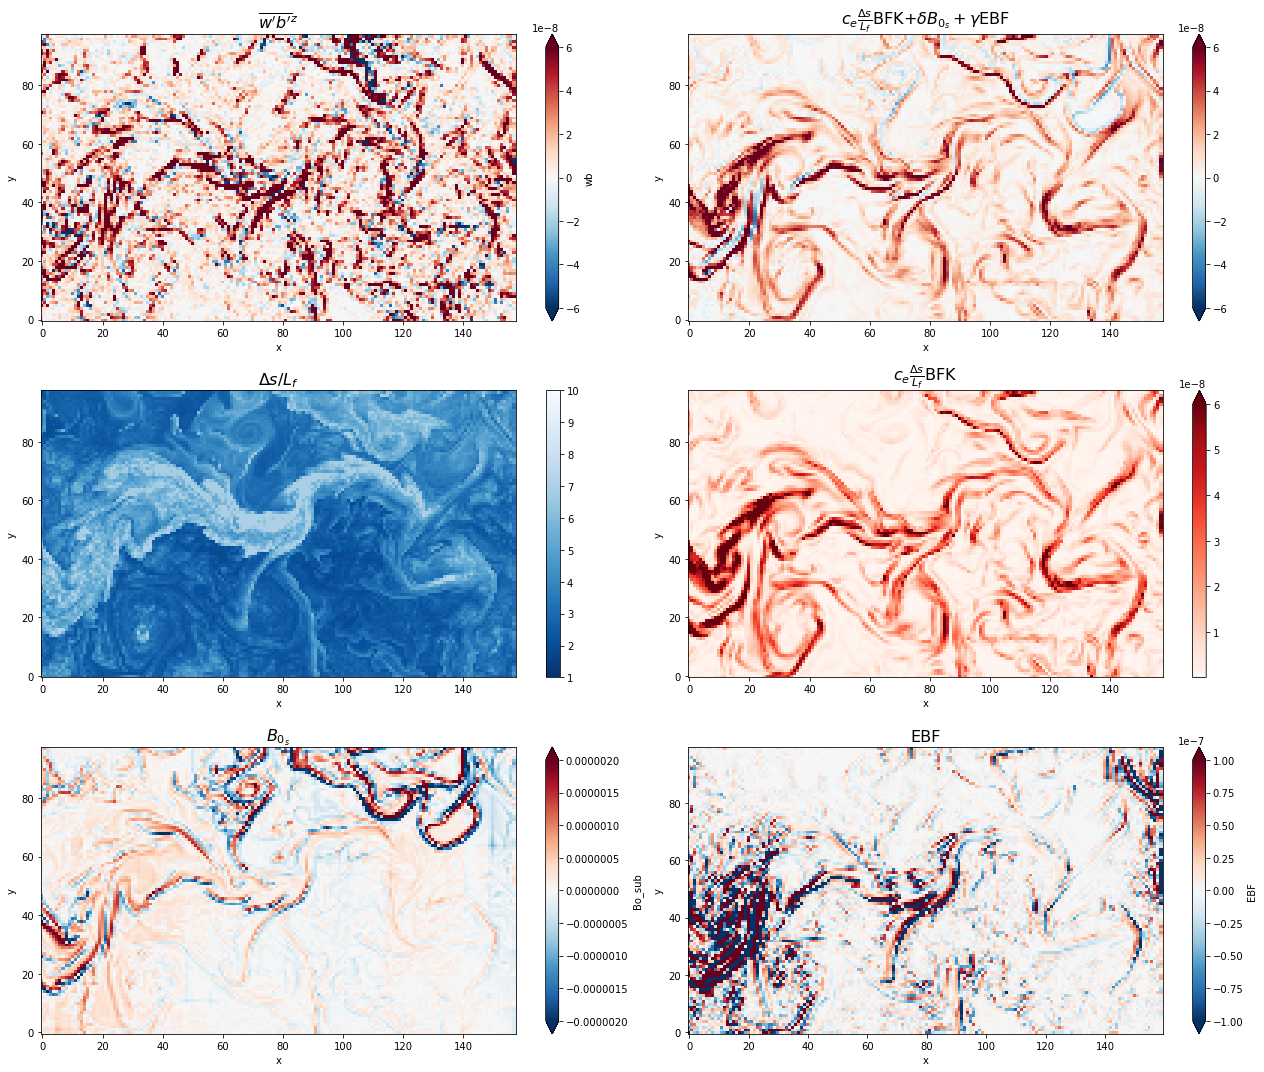

In [27]:
fig, axes = plt.subplots(figsize=(18,15), nrows=3, ncols=2)
fig.set_tight_layout(True)


wsbsb_bar.sel(time_counter='2010-03-01').isel(y=slice(1,-1),
                                              x=slice(1,-1)).plot(ax=axes[0,0], vmax=6e-8, rasterized=True)

(consts_tot[:,0]*boostm
 * BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1),x=slice(1,-1))
).sel(time_counter='2010-03-01').plot(ax=axes[1,1], vmax=6e-8, cmap='Reds', rasterized=True)

# wsbsb_bar.where(wsbsb_bar>0.).sel(time_counter='2010-01-01').plot(ax=axes[0,1], vmax=6e-8, cmap='Reds', rasterized=True)
EBF_bar.sel(time_counter='2010-03-01').plot(ax=axes[2,1], vmax=1e-7, cmap='RdBu_r', rasterized=True)

boostm.sel(time_counter='2010-03-01').plot(ax=axes[1,0], cmap='Blues_r', rasterized=True,
                                           vmin=1.,vmax=1e1)

Bos_b.sel(time_counter='2010-03-01')[-1].isel(y=slice(1,-1),
                                              x=slice(1,-1)).plot(ax=axes[2,0], vmax=2e-6, rasterized=True)
# Bot_b.sel(time_counter='2010-01-01')[-1].isel(y=slice(1,-1),
#                                               x=slice(1,-1)).plot(ax=axes[2,1], vmax=5e-5, rasterized=True)
(consts_tot[:,0]*boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1),x=slice(1,-1))
 + consts_tot[:,1]*Bos_b.isel(y=slice(1,-1),x=slice(1,-1))
 + consts_tot[:,2]*EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))
).sel(time_counter='2010-03-01').plot(ax=axes[0,1], vmax=6e-8, cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"$\overline{w'b'}^z$", fontsize=16)
axes[1,1].set_title(r"$c_e\frac{\Delta s}{L_f}$BFK", fontsize=16)
axes[2,1].set_title(r"EBF", fontsize=16)
axes[1,0].set_title(r"$\Delta s / L_f$", fontsize=16)
axes[2,0].set_title(r"$B_{0_s}$", fontsize=16)
axes[0,1].set_title(r"$c_e\frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s} + \gamma$EBF", fontsize=16)

plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs-meso_EBF-and-Bo_comparison_Mar-01-2010_GulfStreamPatch.pdf')

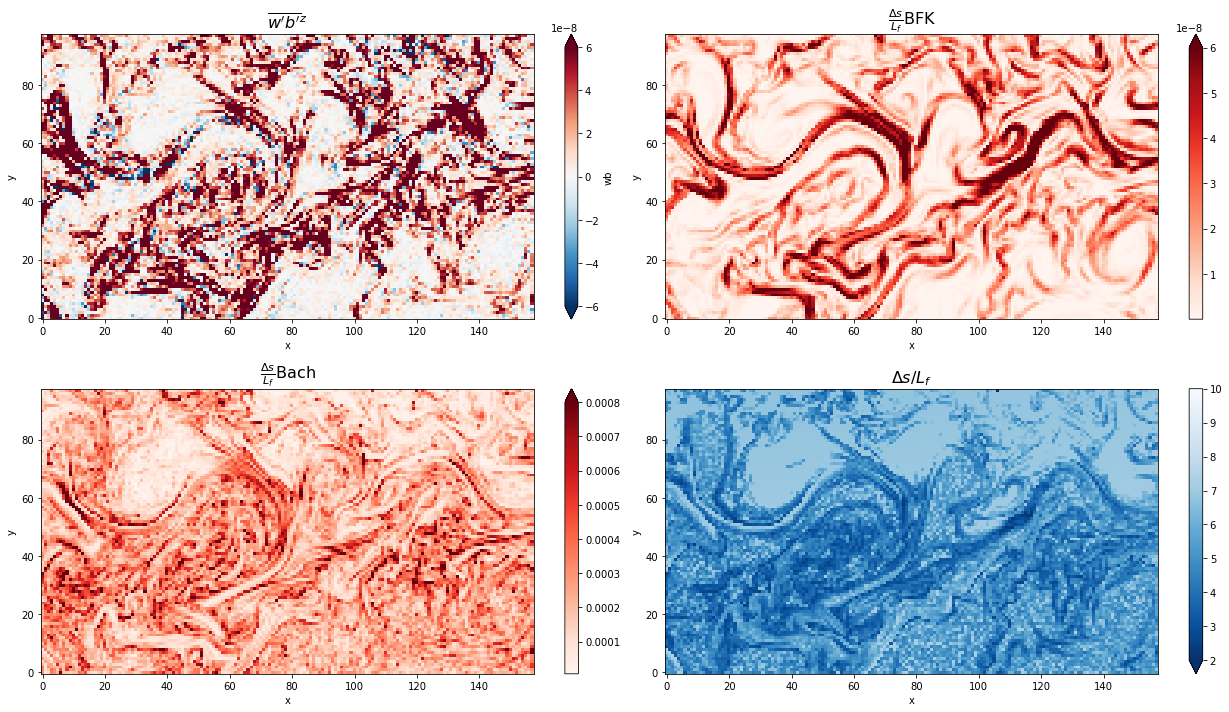

In [37]:
fig, axes = plt.subplots(figsize=(18,10), nrows=2, ncols=2)
fig.set_tight_layout(True)


wsbsb_bar.sel(time_counter='2010-01-01').isel(y=slice(1,-1),
                                              x=slice(1,-1)).plot(ax=axes[0,0], vmax=6e-8, 
                                                                  rasterized=True)

(boostm
 * BFK_bar.where(BFK_bar<1e-6).isel(y=slice(1,-1),x=slice(1,-1))
).sel(time_counter='2010-01-01').plot(ax=axes[0,1], vmax=6e-8, cmap='Reds', rasterized=True)

# wsbsb_bar.where(wsbsb_bar>0.).sel(time_counter='2010-01-01').plot(ax=axes[0,1], vmax=6e-8, 
#                                                                   cmap='Reds', rasterized=True)
(boostm
 * Bach_bar.where(Bach_bar<1e-2).isel(y=slice(1,-1),x=slice(1,-1))
).sel(time_counter='2010-01-01').plot(ax=axes[1,0], vmax=8e-4, cmap='Reds', rasterized=True)

boostm.sel(time_counter='2010-01-01').plot(ax=axes[1,1], cmap='Blues_r', rasterized=True,
                                           vmin=2.,vmax=1e1)


axes[0,0].set_title(r"$\overline{w'b'}^z$", fontsize=16)
axes[0,1].set_title(r"$\frac{\Delta s}{L_f}$BFK", fontsize=16)
axes[1,0].set_title(r"$\frac{\Delta s}{L_f}$Bach", fontsize=16)
axes[1,1].set_title(r"$\Delta s / L_f$", fontsize=16)


plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs-meso_BFK-and-Bach_Jan-01-2010_GulfStreamPatch.pdf')

In [42]:
print(consts.mean('time_counter', skipna=True))
print(const_abs.mean('time_counter',skipna=True))

<xarray.DataArray (coeffs: 3)>
array([ 1.99712402e+01, -6.01402408e-03,  1.98523808e+01])
Dimensions without coordinates: coeffs
<xarray.DataArray (Ce: 1)>
array([25.59247309])
Dimensions without coordinates: Ce


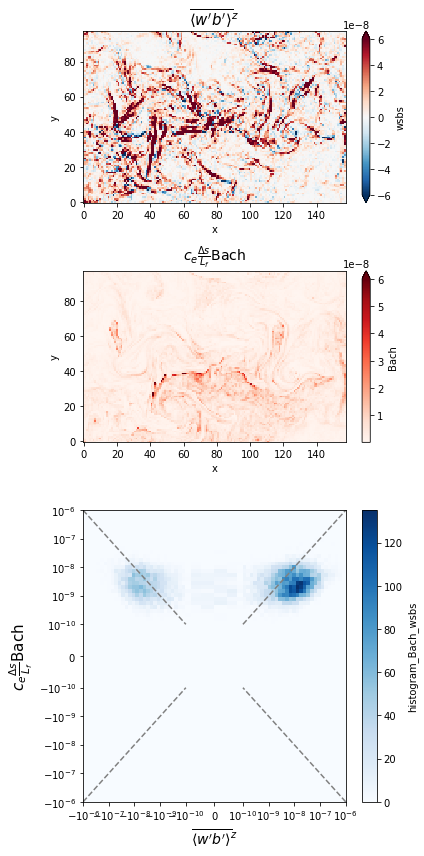

In [38]:
bachH = (Ce_bachb.mean('time_counter')*boostm
         * Bach_bar.where(Bach_bar<1e-2).isel(y=slice(1,-1),x=slice(1,-1))
        )
wsbsb_ML = wsbsb_bar[:]
bachH.name = 'Bach'
wsbsb_ML.name = 'wsbs'

fig = plt.figure(figsize=(6,12))
fig.set_tight_layout(True)
gs = GridSpec(7, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax3 = fig.add_subplot(gs[4:, 0])
# fig = plt.figure(figsize=(14,9))
# # fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsbsb_ML.sel(time_counter='2010-04-01')[0,1:-1,1:-1].plot(ax=ax1, vmax=6e-8, cmap='RdBu_r', 
                                                          rasterized=True)
(bachH.sel(time_counter='2010-04-01'))[:,:,0].plot(ax=ax2, vmax=6e-8, cmap='Reds', 
                                                   rasterized=True)
xhist(bachH.sel(time_counter='2010-04-01').chunk({'time_counter':1}), 
      wsbsb_ML.sel(time_counter='2010-04-01')[:,1:-1,1:-1].chunk({'time_counter':1}),
      bins=[np.concatenate((-np.logspace(-6,-10,30),np.concatenate((np.linspace(-9e-11,9e-11,5),
                                                                    np.logspace(-10,-6,30))))), 
            np.concatenate((-np.logspace(-6,-10,30),np.concatenate((np.linspace(-9e-11,9e-11,5),
                                                                    np.logspace(-10,-6,30)))))]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.plot(np.linspace(1e-6,1e-10), np.linspace(-1e-6,-1e-10), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(-1e-6,-1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-10)
ax3.set_yscale('symlog', linthreshy=1e-10)
ax3.set_ylim([-1e-6,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xlabel(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=14)
ax2.set_title(r"$c_e \frac{\Delta s}{L_f}$Bach", 
              fontsize=14)
ax1.set_title(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=15)
# ax3.set_ylabel(r"$c_e'\frac{\Delta s}{L_f}\frac{H_{\tt ML}^2|\overline{\nabla_{\tt h}\langle b\rangle}^z|^2}{f} \overline{\mu}^z$", 
#               fontsize=15)
ax3.set_ylabel(r"$c_e \frac{\Delta s}{L_f}$Bach", 
               fontsize=15)
# fig.suptitle(r"Jan. 1, 2010", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_Bach-boosted_Apr-01-2010_GulfStreamPatch.pdf')

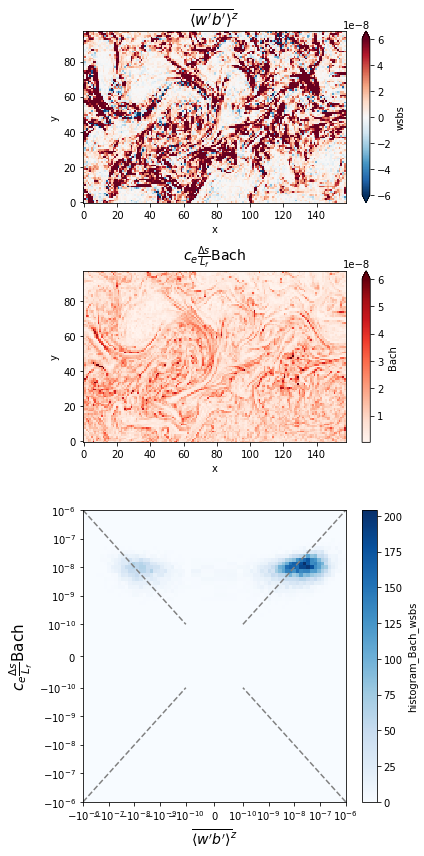

In [45]:
# gradbb2H = (consts_tot[:,0]*boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1),x=slice(1,-1))
#             + consts_tot[:,1]*Bos_b.isel(y=slice(1,-1),x=slice(1,-1))
#             + consts_tot[:,2]*EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))
#            )
# wsbsb_ML = wsbsb_bar[:]
# gradbb2H.name = 'BFK'
# wsbsb_ML.name = 'wsbs'

fig = plt.figure(figsize=(6,12))
fig.set_tight_layout(True)
gs = GridSpec(7, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax3 = fig.add_subplot(gs[4:, 0])
# fig = plt.figure(figsize=(14,9))
# # fig.set_tight_layout(True)
# gs = GridSpec(2,11,figure=fig)
# ax1 = fig.add_subplot(gs[0,:5])
# ax2 = fig.add_subplot(gs[0,6:])
# ax3 = fig.add_subplot(gs[1,1:-1])
wsbsb_ML.sel(time_counter='2010-01-01')[0,1:-1,1:-1].plot(ax=ax1, vmax=6e-8, cmap='RdBu_r', 
                                                          rasterized=True)
(bachH.sel(time_counter='2010-01-01')[:,:,0]).plot(ax=ax2, vmax=6e-8, cmap='Reds', 
                                                   rasterized=True)
xhist(bachH.sel(time_counter='2010-01-01').chunk({'time_counter':1}), 
      wsbsb_ML.sel(time_counter='2010-01-01')[:,1:-1,1:-1].chunk({'time_counter':1}),
      bins=[np.concatenate((-np.logspace(-6,-10,30),np.concatenate((np.linspace(-9e-11,9e-11,5),
                                                                    np.logspace(-10,-6,30))))), 
            np.concatenate((-np.logspace(-6,-10,30),np.concatenate((np.linspace(-9e-11,9e-11,5),
                                                                    np.logspace(-10,-6,30)))))]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.plot(np.linspace(1e-6,1e-10), np.linspace(-1e-6,-1e-10), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(-1e-6,-1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthreshx=1e-10)
ax3.set_yscale('symlog', linthreshy=1e-10)
ax3.set_ylim([-1e-6,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xlabel(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=14)
ax2.set_title(r"$c_e\frac{\Delta s}{L_f}$Bach", 
              fontsize=14)
ax1.set_title(r"$\overline{\langle w'b'\rangle}^{z}$", fontsize=15)
# ax3.set_ylabel(r"$c_e'\frac{\Delta s}{L_f}\frac{H_{\tt ML}^2|\overline{\nabla_{\tt h}\langle b\rangle}^z|^2}{f} \overline{\mu}^z$", 
#               fontsize=15)
ax3.set_ylabel(r"$c_e\frac{\Delta s}{L_f}$Bach", 
               fontsize=15)
# fig.suptitle(r"Jan. 1, 2010", fontsize=17)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_Bach-boosted_Jan-01-2010_GulfStreamPatch.pdf')

###### Nt,Ny,Nx = BFK_bar.shape
deltas = xr.DataArray(np.ones((Nt,1))*np.nan, dims=['time_counter','coeffs'],
                      coords={'time_counter':BFK_bar.time_counter.data})
# cep = xr.DataArray(np.ones(Nt)*np.nan, dims=['time_counter'],
#                    coords={'time_counter':BFK_bar.time_counter.data})

for tt in wsbsb_bar.time_counter:
    wb = wsbsb_bar.sel(time_counter=tt).isel(y=slice(1,-1),
                                             x=slice(1,-1)).fillna(0.).values.reshape((int(Ny*Nx),1))
    bfk = (boost*BFK_bar.where(BFK_bar<1e-8)).fillna(0.).sel(time_counter=tt).values.reshape((int(Ny*Nx),1))
    bo = Bos_b[23::24].sel(time_counter=tt).fillna(0.).isel(y=slice(1,-1),
                                                            x=slice(1,-1)).values.reshape((int(Ny*Nx),1))
    
    deltas.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(bo),
                                            wb - bfk*consts[:,-1].mean('time_counter',skipna=True).values
                                           ).ravel()
#     cep.sel(time_counter=tt)[:] = np.dot(np.linalg.pinv(bfk),wb).ravel()
#     print(tt)

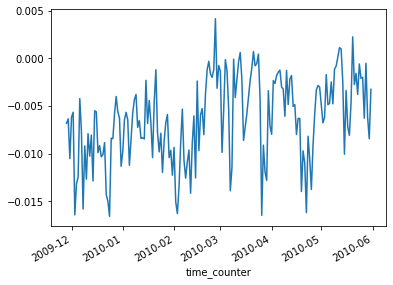

In [29]:
deltas.plot()

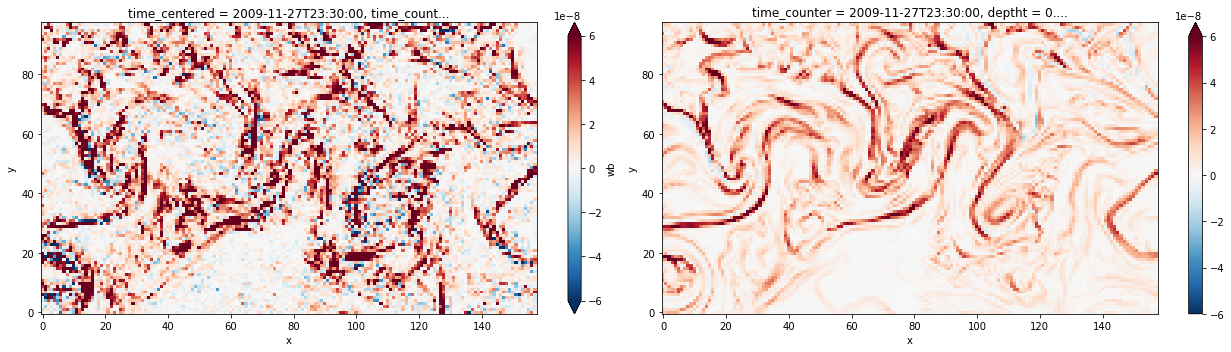

In [17]:
fig, axes = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
wsbsb_bar.isel(time_counter=0,y=slice(1,-1),x=slice(1,-1)).plot(ax=axes[0], vmax=6e-8, cmap='RdBu_r',
                                                                rasterized=True)
(1.*((boost*BFK_bar.where(BFK_bar<1e-8)).isel(time_counter=0)*consts[0,0]
 + Bos_b[23::24].isel(time_counter=0,y=slice(1,-1),x=slice(1,-1))*consts[0,1])
).plot(ax=axes[1], vmax=6e-8, cmap='RdBu_r', rasterized=True)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_GulfStream_2009-11-27.pdf')

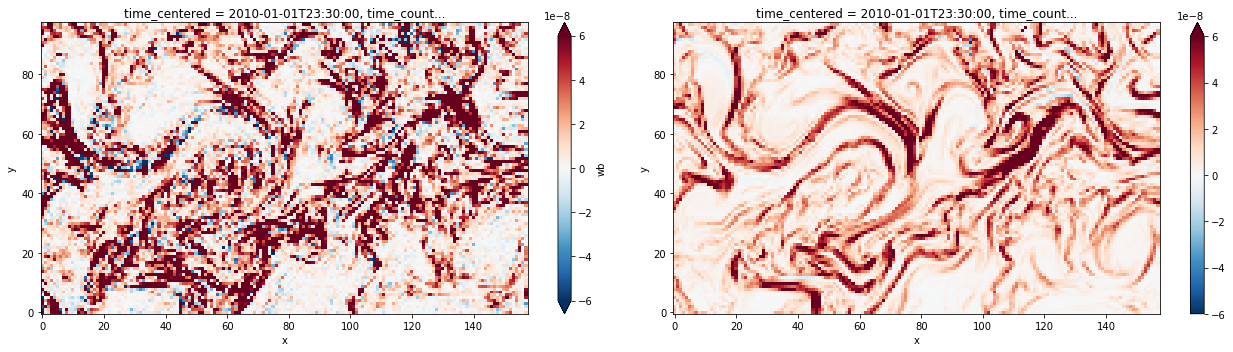

In [18]:
fig, axes = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
wsbsb_bar.sel(time_counter='2010-01-01').isel(y=slice(1,-1),x=slice(1,-1)).plot(ax=axes[0], vmax=6e-8, cmap='RdBu_r')
((boost*BFK_bar.where(BFK_bar<1e-8)*consts[:,0]).sel(time_counter='2010-01-01')
 + (Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))
    * consts[:,1]).sel(time_counter='2010-01-01')
).plot(ax=axes[1], vmax=6e-8, cmap='RdBu_r')
# plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_GulfStream_2009-11-27.pdf')

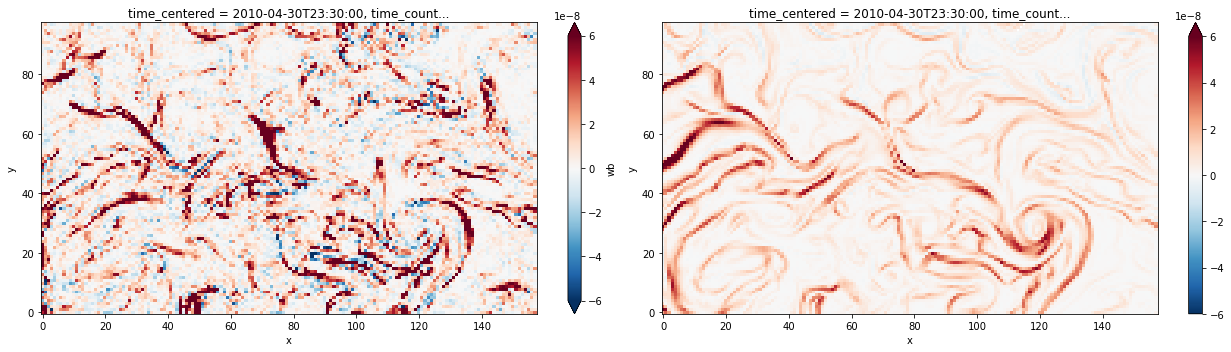

In [11]:
fig, axes = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
wsbsb_bar.sel(time_counter='2010-04-30').isel(y=slice(1,-1),
                                              x=slice(1,-1)).plot(ax=axes[0], vmax=6e-8, cmap='RdBu_r',
                                                                  rasterized=True)
(1.*((boost*BFK_bar.where(BFK_bar<1e-8) * consts[:,0]).sel(time_counter='2010-04-30')
 + (Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))
    * consts[:,1]).sel(time_counter='2010-04-30'))
).plot(ax=axes[1], vmax=6e-8, cmap='RdBu_r', rasterized=True)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_GulfStream_2010-04-30.pdf')

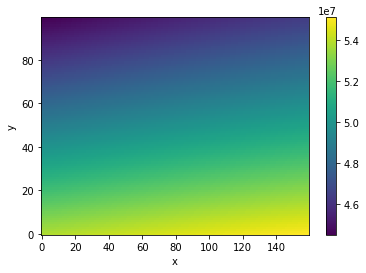

In [19]:
Atb.plot()

In [43]:
# Ce = 2.4e1
# wsbs = ((wsbsb_bar[:]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
# wsbs = ((wsbsb_bar[:]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
# wsTs = ((wsTsb_bar[:]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
# wsSs = ((wsSsb_bar[:]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
wsbs = wsbsb_bar.load().median(['y','x'],skipna=True)
# wsbs_abs = np.abs(wsbsb_bar).load().median(['y','x'],skipna=True)
# wsbs_pos = wsbsb_bar.where(wsbsb_bar>0.).load().median(['y','x'],skipna=True)

mld_max = MLD_b.max(['y','x'],skipna=True)
mld = MLD_b.load().median(['y','x'],skipna=True)
# wsTs = wsTsb_bar.load().median(dim=['y','x'])
# wsSs = wsSsb_bar.load().median(dim=['y','x'])
# Bot = ((Bot_b.where(Bot_b<1e-2)[23::24]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# Bos = ((Bos_b.where(Bos_b<1e-3)[23::24]*Atb).sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# bfk = ((boostm*BFK_bar.where(BFK_bar<1e-8)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# ce_bfk = ((Ce_bar.mean('time_counter',skipna=True)
#            * boost*BFK_bar.where(BFK_bar<1e-8)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#            * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#           )
Bot = Bot_b.sel(y=slice(1,-1),x=slice(1,-1)).load().median(dim=['y','x'], skipna=True) 
Bos = Bos_b.sel(y=slice(1,-1),x=slice(1,-1)).load().median(dim=['y','x'], skipna=True)
bachb = (boostm*Bach_bar.where(Bach_bar<1e-2).sel(y=slice(1,-1),x=slice(1,-1)) 
        ).load().median(dim=['y','x'], skipna=True) 
bach = (Bach_bar.where(Bach_bar<1e-2).sel(y=slice(1,-1),x=slice(1,-1)) 
       ).load().median(dim=['y','x'], skipna=True) 
bfk = (boostm*BFK_bar.where(BFK_bar<1e-6).sel(y=slice(1,-1),x=slice(1,-1)) 
      ).load().median(dim=['y','x'], skipna=True) 
# bfk_cons = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))
#             * consts[:,-1].mean('time_counter',skipna=True)
#            ).load().median(dim=['y','x'], skipna=True) 
# abs_bfk = (boost*BFK_bar.where(BFK_bar<1e-8) * const_abs
#           ).load().median(dim=['y','x'],skipna=True)
# pos_bfk = (boostm * BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1)) * const_pos[:,0]
#           ).load().median(dim=['y','x'],skipna=True)
# net = (((2e1*boost*BFK_bar.where(BFK_bar<1e-6)
#          + 1e-1*Bos_b.sel(y=slice(1,-1),x=slice(1,-1))
#         )*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# net = (((Ce*boost*BFK_bar.where(BFK_bar<1e-6)
#          + 1e-4*Bot_b.sel(y=slice(1,-1),x=slice(1,-1))
#         )*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# net = (((boost*BFK_bar.where(BFK_bar<1e-8)*consts[:,0]
#          + Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))*consts[:,1]
#         )*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# net_cons = (((boost*BFK_bar.where(BFK_bar<1e-8)*consts[:,0].mean('time_counter',skipna=True)
#               + Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))
#               * consts[:,1].mean('time_counter',skipna=True)
#              )*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#             * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#            )
# net = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))*consts_tot[:,0]
#        + Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))*consts_tot[:,1]
#        + EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))*consts_tot[:,2]
#       ).load().median(dim=['y','x'],skipna=True) 
# net_pos = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))*const_pos[:,0]
#            + Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))*const_pos[:,1]
#            + EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))*const_pos[:,2]
#           ).load().median(dim=['y','x'],skipna=True) 
# net_EBF = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))*consts_EBF[:,0]
#            + EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))*consts_EBF[:,1]
#           ).load().median(dim=['y','x'],skipna=True)
# net_Bo = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))*consts_Bo[:,0]
#            + Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))*consts_Bo[:,1]
#           ).load().median(dim=['y','x'],skipna=True)
# net_cons2 = (boost*BFK_bar.where(BFK_bar<1e-8)*consts[:,-1].mean('time_counter',skipna=True)
#              + Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))
#              * deltas
#             ).load().median(dim=['y','x'],skipna=True) 

# bfk = ((BFK_2010.where(BFK_2010<1e-4)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# abfkt = ((1e1*g*alpha_b.sel(y=slice(1,-1),x=slice(1,-1))*BFKt_bar.where(BFKt_bar<1e3)
#           * Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#          * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#         )
# bfkt = ((1e-7*BFKt_bar.where(BFKt_bar<1e3)
#          * Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
# bbfks = ((1e1*g*beta_b.sel(y=slice(1,-1),x=slice(1,-1))*BFKs_bar.where(BFKs_bar<1e3)
#           * Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#          * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#         )
# omdt = ((Omdt_bar.where(np.abs(Omdt_bar)<1e-2)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# omds = ((Omds_bar.where(np.abs(Omds_bar)<1e-1)*Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#       )
# omdt = Omdt_bar.load().median(dim=['y','x'])
# omds = Omds_bar.load().median(dim=['y','x'])
# omdt
bach

<xarray.DataArray 'Bach' (time_counter: 150)>
array([4.22805356e-05, 3.63409938e-05, 3.55816338e-05, 3.62540735e-05,
       3.24280764e-05, 2.84736246e-05, 2.92765906e-05, 3.18226587e-05,
       3.46025779e-05, 3.81258434e-05, 4.27037656e-05, 4.40922393e-05,
       4.23457946e-05, 4.68964970e-05, 4.57070413e-05, 4.35310602e-05,
       4.66463229e-05, 4.44310489e-05, 4.13299528e-05, 3.83304265e-05,
       4.21822942e-05, 4.42139372e-05, 4.61858119e-05, 4.98116855e-05,
       4.98732177e-05, 5.10072727e-05, 4.36512946e-05, 4.27375310e-05,
       4.53000871e-05, 5.18029258e-05, 5.21673389e-05, 5.61356082e-05,
       6.12451889e-05, 5.60032828e-05, 6.37018761e-05, 7.26955586e-05,
       7.72314299e-05, 6.76755045e-05, 7.35046204e-05, 7.47805304e-05,
       7.22315955e-05, 6.55437119e-05, 7.54688837e-05, 7.88817418e-05,
       7.74292614e-05, 8.00111574e-05, 8.01134455e-05, 7.32553808e-05,
       6.31236114e-05, 6.70099885e-05, 6.83688735e-05, 6.30996741e-05,
       6.11201973e-05, 6.26238113e-05, 6.29110914e-05, 6.07641656e-05,
       6.04153848e-05, 5.95497482e-05, 4.41431683e-05, 4.71374165e-05,
       4.70476013e-05, 4.38288391e-05, 3.93234176e-05, 3.98576049e-05,
       4.23690282e-05, 4.28042528e-05, 3.89617396e-05, 3.85042603e-05,
       3.58029164e-05, 3.85094476e-05, 3.60198755e-05, 4.44465550e-05,
       5.06788594e-05, 4.78880536e-05, 4.82992306e-05, 4.74687974e-05,
       4.52480151e-05, 3.71431177e-05, 2.81809058e-05, 2.12260080e-05,
       1.41300389e-05, 1.93122815e-05, 1.87390319e-05, 3.11949495e-05,
       3.13747419e-05, 3.07205083e-05, 4.02405091e-05, 3.66016894e-05,
       2.61458715e-05, 1.96933817e-05, 1.37940457e-05, 1.29267701e-05,
       1.08876264e-05, 9.68377063e-06, 8.34884149e-06, 6.74956282e-06,
       8.09053285e-06, 7.58494755e-06, 6.72384564e-06, 7.69723269e-06,
       7.92574422e-06, 7.48223071e-06, 4.89815240e-06, 6.08970190e-06,
       1.04153184e-05, 1.28688289e-05, 1.42269263e-05, 1.07173562e-05,
       1.10915033e-05, 1.35445056e-05, 1.57885443e-05, 1.34106551e-05,
       1.52712826e-05, 1.53720105e-05, 1.83320989e-05, 1.65050832e-05,
       1.53776935e-05, 1.02178742e-05, 1.31002155e-05, 1.66128318e-05,
       1.85097452e-05, 1.72941357e-05, 1.53444157e-05, 1.15132939e-05,
       1.23591614e-05, 1.20670695e-05, 1.15917104e-05, 7.33776307e-06,
       4.85945182e-06, 5.35332359e-06, 6.38515608e-06, 8.25526990e-06,
       1.02245636e-05, 1.51316900e-05, 1.39472085e-05, 1.48970842e-05,
       1.59462033e-05, 1.37217592e-05, 1.11674608e-05, 7.84289579e-06,
       7.07654445e-06, 7.26185550e-06, 5.89105665e-06, 4.70813501e-06,
       5.46043883e-06, 6.86408420e-06, 6.51791428e-06, 8.33056198e-06,
       1.08452873e-05, 7.09729764e-06])
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T23:30:00 ... 2010-05-30T23:30:00
    time_centered  (time_counter) datetime64[ns] 2010-01-01T23:30:00 ... 2010-05-30T23:30:00

In [18]:
tflx = (((qt_bar*rho0**-1*Cp**-1*Atb).sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
       )
bflx = (((g*alpha_b*qt_bar*rho0**-1*Cp**-1*Atb).sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
       )
tnet = (((6.4e-4*alpha_b.sel(y=slice(1,-1),x=slice(1,-1))*BFKt_bar.where(BFKt_bar<1e3)
          + 1.5e-2*qt_bar.sel(y=slice(1,-1),x=slice(1,-1),time_counter=slice('2010-02-24',None))*rho0**-1*Cp**-1
         ) * Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
       )
bnet = (((1.5e-1*BFK_bar.where(BFK_bar<1e-4)
          + 1.5e-2*g*(alpha_b*qt_bar).sel(y=slice(1,-1),x=slice(1,-1))*rho0**-1*Cp**-1
         ) * Atb.sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
        * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
       )
# sflx = (((so_b*MLD_b*Atb).sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
# tflx = (((qt_b*Atb).sel(y=slice(1,-1),x=slice(1,-1))).sum(dim=['y','x']) 
#         * Atb.sel(y=slice(1,-1),x=slice(1,-1)).sum(dim=['y','x'])**-1
#        )
tnet

NameError: name 'qt_bar' is not defined

(array([3.11000e+02, 5.10000e+02, 1.06600e+03, 3.19600e+03, 1.83347e+05,
        5.75690e+05, 4.99800e+03, 1.36200e+03, 6.21000e+02, 3.92000e+02]),
 array([-0.01 , -0.008, -0.006, -0.004, -0.002,  0.   ,  0.002,  0.004,
         0.006,  0.008,  0.01 ]),
 <a list of 10 Patch objects>)

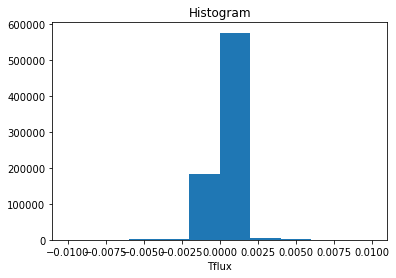

In [19]:
Omdt_bar.plot(range=(-.01,.01))

(array([8.70000e+01, 1.69000e+02, 3.19000e+02, 9.67000e+02, 4.44539e+05,
        3.25837e+05, 9.53000e+02, 3.01000e+02, 1.50000e+02, 9.80000e+01]),
 array([-0.01 , -0.008, -0.006, -0.004, -0.002,  0.   ,  0.002,  0.004,
         0.006,  0.008,  0.01 ]),
 <a list of 10 Patch objects>)

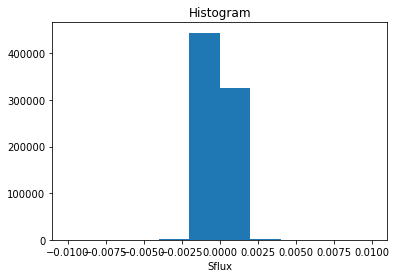

In [20]:
Omds_bar.plot(range=(-.01,.01))

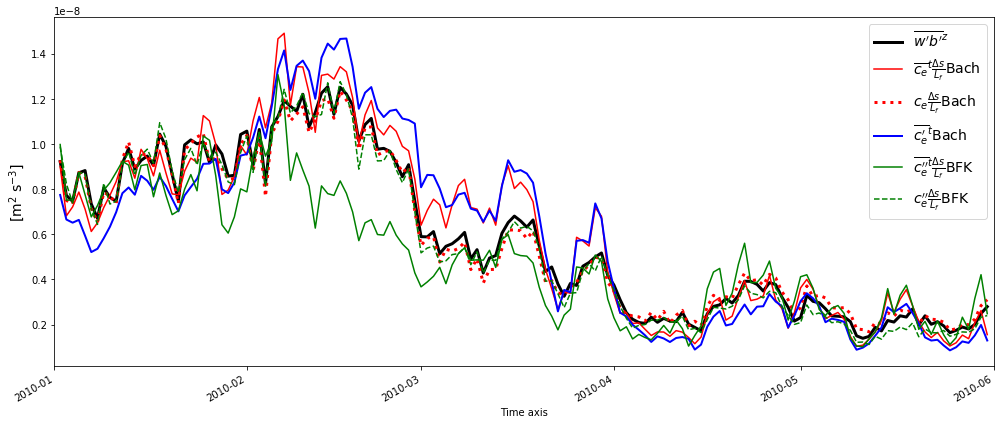

In [44]:
fig, ax = plt.subplots(figsize=(14,6))
fig.set_tight_layout(True)
# ax2 = ax.twinx()
# ax3 = ax.twinx()

wsbs.sel(time_counter=slice('2010-01-01',None)).plot(ax=ax, c='k', lw=3, 
                                                     label=r"$\overline{w'b'}^z$")
(Ce_bachb.median('time_counter')*bachb).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax, 
                                                                                      c='r',
                                            label=r"$\overline{c_e}^t\frac{\Delta s}{L_f}$Bach")
(Ce_bachb*bachb).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax, c='r', ls=':', lw=3,
                                            label=r"$c_e \frac{\Delta s}{L_f}$Bach")
(Ce_bach.median('time_counter')*bach).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax, 
                                                                                    c='b', lw=2, 
                                                          label=r"$\overline{c_e'}^t$Bach")
(Ce_bfk.median('time_counter')*bfk).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax, c='g', 
                                                    label=r"$\overline{c_e''}^t\frac{\Delta s}{L_f}$BFK")
(Ce_bfk*bfk).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax, c='g', ls='--', 
                                                    label=r"$c_e'' \frac{\Delta s}{L_f}$BFK")

# ax2.spines['right'].set_color('g')
# ax2.tick_params(axis='y', colors='g', labelsize=13)
ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=14)
# ax2.set_ylabel(r" [m$^2$s$^{-3}$]", fontsize=14, color='g')
ax.legend(loc='upper right', fontsize=14)

ax.set_xlim(['2010-01-01','2010-06-01'])
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbsmeso_BFK-and-Bach_GulfStream_2010-01-01_2010-05-30.pdf')

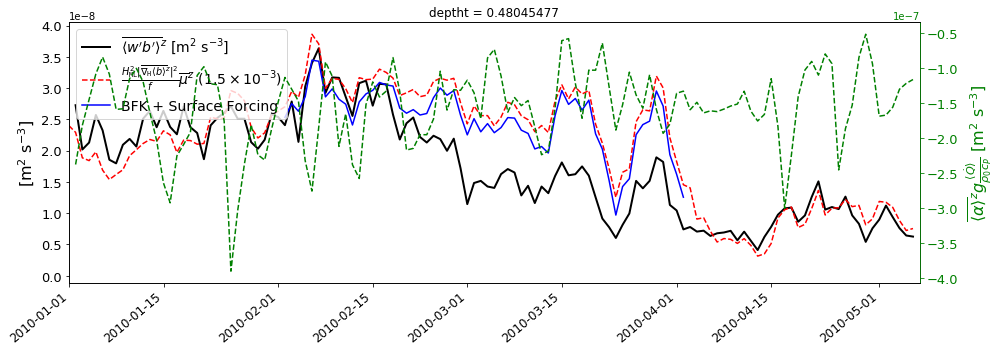

In [16]:
fig, ax1 = plt.subplots(figsize=(14,5))
fig.set_tight_layout(True)
ax2 = ax1.twinx()
# ax3 = ax1.twinx()
# ax4 = ax1.twinx()
# ax5 = ax.twinx()
# ax6 = ax5.twinx()

# ax3.spines['left'].set_position(('axes',-0.058))
# ax4.spines['left'].set_position(('axes',-0.12))
# ax5.spines['right'].set_position(('axes',1.068))
# ax6.spines['right'].set_position(('axes',1.138))


wsbs.sel(time_counter=slice(None,None)).plot(ax=ax1, color='k', lw=2,
                                            label=r"$\overline{\langle w'b'\rangle}^z$ [m$^2$ s$^{-3}$]")
(.15*bfk_tot).sel(time_counter=slice(None,None)).plot(ax=ax1, color='r', ls='--',
                                label=r"$\frac{H_{\tt XL}^2|\overline{\nabla_{\tt h}\langle b\rangle}^z|^2}{f} \overline{\mu}^z$ "
               + r"$(1.5 \times 10^{-3})$")
bnet.sel(time_counter=slice('2010-02-01','2010-04-01')).plot(ax=ax1, color='b', label=r"BFK + Surface Forcing")
(bflx).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax2, color='g', ls='--')



ax1.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=16)
ax2.set_ylabel(r"$\overline{\langle\alpha\rangle}^z g \frac{\langle\dot{Q}\rangle}{\rho_0 c_P}$ [m$^2$ s$^{-3}$]", 
               fontsize=16, c='g')
# ax6.set_ylabel(r"$\frac{g\alpha\langle Q\rangle }{\rho_0 c_P}$ [m$^2$ s$^{-3}$]", fontsize=16, c='b')
# ax6.set_ylabel(r"$\langle\dot{S}\rangle H_{\tt ML}$ [kg m$^{-1}$ s$^{-1}$]", fontsize=16, c='g')
ax1.set_xlabel(r"")
# ax5.set_xlabel(r"")


ax1.set_xlim(['2010-01-01','2010-05-07'])
# ax1.set_xticklabels([])
ax1.tick_params(axis='x', labelsize=12, labelrotation=40)
# ax1.set_xlim(['2009-08-01','2010-05-10'])
ax1.tick_params(axis='y', labelsize=13)
# ax5.tick_params(axis='x', labelsize=13, labelrotation=40)
ax2.spines['right'].set_color('g')
ax2.tick_params(axis='y', colors='g', labelsize=13)
# ax5.spines['left'].set_color('r')
# ax5.tick_params(axis='y', colors='r', labelsize=13)
# ax6.spines['right'].set_color('b')
# ax6.tick_params(axis='y', colors='b', labelsize=13)
# ax3.spines['left'].set_color('b')
# ax3.tick_params(axis='y', colors='b', labelsize=13)
# ax4.spines['left'].set_color('g')
# ax4.tick_params(axis='y', colors='g', labelsize=13)
# ax5.set_ylim([-27,0])
ax1.legend(loc='lower left', fontsize=14)

# ax3.yaxis.set_label_position('left')
# ax3.yaxis.set_ticks_position('left')
# ax4.yaxis.set_label_position('left')
# ax4.yaxis.set_ticks_position('left')

plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbsXL-BFK_GulfStream_2010-01-01_2010-05-05.pdf')

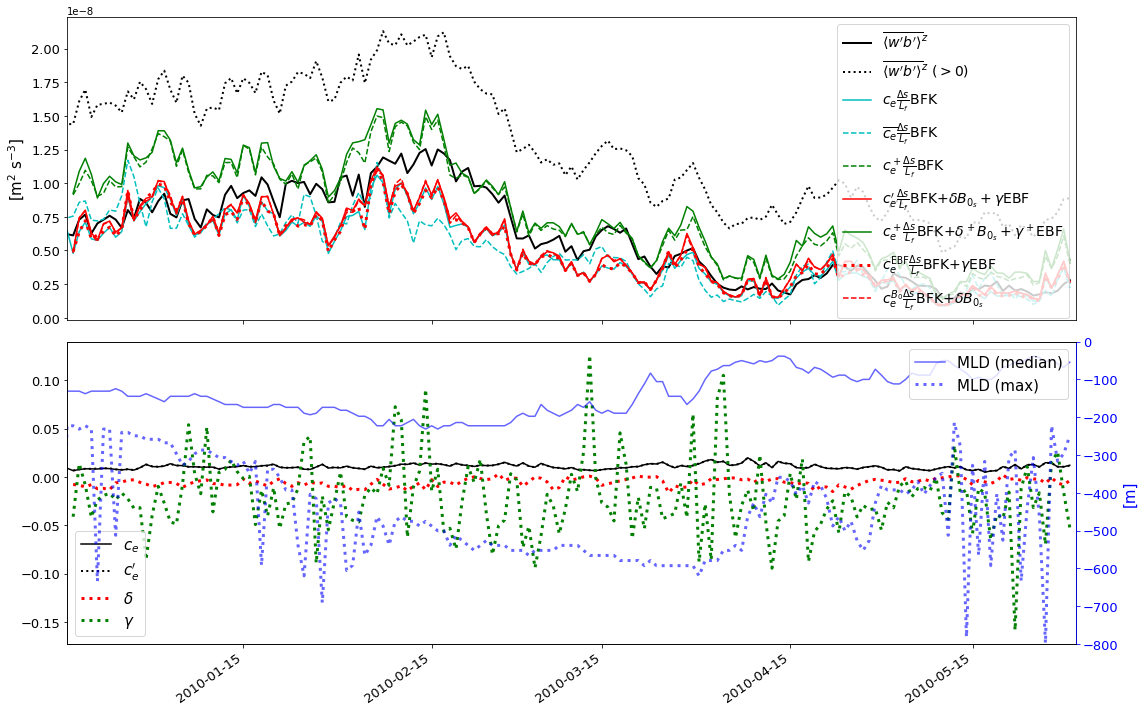

In [30]:
fig, (ax1,ax2) = plt.subplots(figsize=(16,10), nrows=2, ncols=1)
fig.set_tight_layout(True)
# ax2 = ax1.twinx()
ax3 = ax2.twinx()
# ax4 = ax1.twinx()
# ax5 = ax.twinx()
# ax6 = ax5.twinx()

# ax3.spines['left'].set_position(('axes',-0.059))
# ax4.spines['left'].set_position(('axes',-0.12))
# ax5.spines['right'].set_position(('axes',1.068))
# ax6.spines['right'].set_position(('axes',1.138))


ax1.plot(wsbs.time_counter, wsbs, color='k', lw=2, label=r"$\overline{\langle w'b'\rangle}^z$")
# wsbs_abs.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax1, color='k', ls='--', lw=2, 
#                                                      label=r"$|\overline{\langle w'b'\rangle}^z|$")
ax1.plot(wsbs_pos.time_counter, wsbs_pos, color='k', ls=':', lw=2, label=r"$\overline{\langle w'b'\rangle}^z\ (>0)$")
ax1.plot(bfk.time_counter.data, bfk.data, color='c', ls='-', label=r"$c_e\frac{\Delta s}{L_f}$BFK")
ax1.plot(bfk_cons.time_counter.data, bfk_cons.data, color='c', ls='--', label=r"$\overline{c_e}\frac{\Delta s}{L_f}$BFK")
ax1.plot(pos_bfk.time_counter.data, pos_bfk.data, color='g', ls='--', label=r"$c_e^+\frac{\Delta s}{L_f}$BFK")
# abs_bfk.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax1, color='r', ls='--', lw=2,
#                                                         label=r"$c_e'$BFK")
# ax1.plot(pos_bfk.time_counter.data, pos_bfk.data, color='c', ls=':', lw=3, label=r"$c_e^+$BFK")
# bfk.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax1, color='c', ls=':', lw=2,
#                 label=r"$\overline{c_e'}$BFK")
ax1.plot(net.time_counter.data, net.data, color='r', ls='-', 
         label=r"$c_e'\frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s} + \gamma$EBF")
ax1.plot(net_pos.time_counter.data, net_pos.data, color='g', ls='-', 
         label=r"$c_e^+\frac{\Delta s}{L_f}$BFK$+ \delta^+ B_{0_s} + \gamma^+$EBF")
ax1.plot(net_EBF.time_counter.data, net_EBF.data, color='r', ls=':', lw=3, 
         label=r"$c_e^{\tt EBF}\frac{\Delta s}{L_f}$BFK$ + \gamma$EBF")
ax1.plot(net_Bo.time_counter.data, net_Bo.data, color='r', ls='--',
         label=r"$c_e^{B_0}\frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s}$")
# (1*net_cons2).sel(time_counter=slice('2009-11-07',None)).plot(ax=ax1, color='g', ls='-',
#                                                         label=r"$\overline{c_e'}$BFK $+\delta B_{0_s}$")
# Bos.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax3, color='grey', ls='-',
#                                                     label=r"$B_0$ (submeso)")

(-mld).plot(ax=ax3, color='b', ls='-', alpha=.6, label=r"MLD (median)")
(-mld_max).plot(ax=ax3, color='b', ls=':', alpha=.6, lw=3, label=r"MLD (max)")

(consts[:,-1]*1e-2).plot(ax=ax2, color='k', ls='-', label=r"$c_e$")
# consts[:,1].plot(ax=ax2, color='g', ls='-', label=r"$\delta$")
(consts_tot[:,0]*1e-2).plot(ax=ax2, color='k', ls=':', lw=2, label=r"$c_e'$")
consts_tot[:,1].plot(ax=ax2, color='r', ls=':', lw=3, label=r"$\delta$")
consts_tot[:,2].plot(ax=ax2, color='g', ls=':', lw=3, label=r"$\gamma$")
# Bos.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax2, color='g', ls='--',
#                                                     label=r"$B_0$ (submeso)")


# ax2.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=15, c='g')
# (bfk).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax5, color='r', ls='-')
# (0.*wsSs).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax4, color='g', ls='--', lw=1)
# (0.*sflx).plot(ax=ax6, color='g', ls='--', lw=1)
# im6, = (.02*tflx.roll(time_counter=-1)[:-1]).plot(ax=ax5, color='b', lw=2)
# (sflx).plot(ax=ax6, color='g')


# ax1.set_ylabel(r"$\overline{\langle w'b'\rangle}^z$ [m$^2$ s$^{-3}$]", fontsize=16)
ax1.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=15)
ax3.set_ylabel(r"[m]", fontsize=15, color='b')
# ax3.set_ylabel(r"$\overline{\langle w'\theta'\rangle}^z$ $(\times 10^{-5})$ [m $^\circ$C s$^{-1}$]", fontsize=16, c='b')
# ax4.set_ylabel(r"$\overline{\langle w's'\rangle}^z$ $(\times 10^{-5})$ [m (g/kg) s$^{-1}$]", fontsize=16, c='g')
# ax2.set_ylabel(r"$\frac{H_{\tt ML}^2|\overline{\nabla_{\tt H}\langle b\rangle}^z|^2}{f} \overline{\mu}^z$ "
#                + r"$(2\times 10^{-3})$", 
#                fontsize=16, c='r')
# ax6.set_ylabel(r"$\frac{g\alpha\langle Q\rangle }{\rho_0 c_P}$ [m$^2$ s$^{-3}$]", fontsize=16, c='b')
# ax6.set_ylabel(r"$\langle\dot{S}\rangle H_{\tt ML}$ [kg m$^{-1}$ s$^{-1}$]", fontsize=16, c='g')
ax1.set_xlabel(r"")
ax2.set_xlabel(r"")
ax2.set_ylabel(r"")
# ax3.set_ylabel(r"MLD")
ax1.set_title(r"")
ax2.set_title(r"")
ax3.set_title(r"")
# ax5.set_xlabel(r"")


ax1.set_xlim(['2009-12-17','2010-06-01'])
ax1.set_xticks(['2010-01-15','2010-02-15','2010-03-15','2010-04-15','2010-05-15'])
ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=13)
ax2.set_xlim(['2009-12-17','2010-06-01'])
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xticks(['2010-01-15','2010-02-15','2010-03-15','2010-04-15','2010-05-15'])
ax2.set_xticklabels(['2010-01-15','2010-02-15','2010-03-15','2010-04-15','2010-05-15'],
                    fontsize=13, rotation=35)
ax3.set_ylim([-800,0])
# ax1.set_xticklabels([])
# ax.tick_params(axis='x', labelsize=13, labelrotation=40)
# ax5.set_xlim(['2010-01-01','2010-05-07'])
# ax.tick_params(axis='y', labelsize=13)
# ax5.tick_params(axis='x', labelsize=13, labelrotation=40)
ax2.spines['left'].set_color('k')
ax2.tick_params(axis='y', colors='k', labelsize=13)
# ax5.spines['left'].set_color('r')
# ax5.tick_params(axis='y', colors='r', labelsize=13)
# ax6.spines['right'].set_color('b')
# ax6.tick_params(axis='y', colors='b', labelsize=13)
ax3.spines['right'].set_color('b')
ax3.tick_params(axis='y', colors='b', labelsize=13)
# ax4.spines['left'].set_color('g')
# ax4.tick_params(axis='y', colors='g', labelsize=13)
# ax5.set_ylim([-27,0])

# ax3.yaxis.set_label_position('left')
# ax3.yaxis.set_ticks_position('left')
# ax4.yaxis.set_label_position('left')
# ax4.yaxis.set_ticks_position('left')

ax1.legend(loc='upper right', fontsize=14)
ax2.legend(loc='lower left', fontsize=15)
ax3.legend(loc='upper right', fontsize=15)

plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbsmeso_EBF-and-Bo_GulfStream_2009-12-17_2010-05-30.pdf')

# What about a least absolute deviation fit?

In [11]:
def lad_fit(X, params):
    return X.dot(params)

def cost_func(params, X, y):
    return np.sum(np.abs(y - lad_fit(X, params)))


# def lad_fit2D(X, params):
#     return X.dot(params[:2]) + params[2]

# def cost_func2D(params, X, y):
#     return np.sum(np.abs(y - lad_fit2D(X, params)))

In [47]:
x0 = .9
Nt,Ny,Nx = BFK_bar.sel(time_counter=slice('2009-12-17',None)).shape
Ce_lad = xr.DataArray(np.ones((Nt))*np.nan, dims=['time_counter'],
                      coords={'time_counter':BFK_bar.time_counter.sel(time_counter=slice('2009-12-17',None)).data})
i = 0
for tt in wsbsb_bar.time_counter.sel(time_counter=slice('2009-12-17',None)):
    
    bfk = np.ma.masked_invalid((boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1), 
                                                                        x=slice(1,-1))).sel(time_counter=tt))
    wb = np.ma.masked_invalid(wsbsb_bar.isel(y=slice(1,-1), x=slice(1,-1)).sel(time_counter=tt))
    bfk_comp = np.ma.masked_array(bfk, wb.mask).compressed()
    wb_comp = np.ma.masked_array(wb, bfk.mask).compressed()
    
    Ce_lad[i] = minimize(cost_func, x0, args=(bfk_comp.reshape((len(bfk_comp),1)), wb_comp)
                        ).x[0]
    i += 1
    
Ce_lad
# y_hat = lad_fit(X, output.x)

<xarray.DataArray (time_counter: 165)>
array([0.36192403, 0.40515032, 0.47218362, 0.40735618, 0.49424152,
       0.48857921, 0.46354697, 0.38921801, 0.35517459, 0.42366337,
       0.35060348, 0.48471781, 0.60891699, 0.54635824, 0.56320138,
       0.6078674 , 0.84497981, 0.60791612, 0.58375765, 0.64692787,
       0.56792711, 0.44349646, 0.50297348, 0.46368596, 0.38359058,
       0.50433839, 0.55400981, 0.54916992, 0.61697112, 0.58050668,
       0.58678927, 0.64577978, 0.815685  , 0.83427046, 0.62866581,
       0.59148698, 0.52242796, 0.59097252, 0.42680936, 0.46251196,
       0.50250079, 0.82132739, 0.5949833 , 0.48436276, 0.5024867 ,
       0.66710687, 0.51083218, 0.49746042, 0.47763895, 0.64967594,
       0.49482026, 0.45215771, 0.56162815, 0.58955775, 0.70828805,
       0.71919062, 0.9       , 0.81795653, 0.9       , 0.70971091,
       0.83369978, 0.82103481, 0.83251072, 0.9       , 0.9       ,
       0.83741172, 0.83319351, 0.9       , 0.84392107, 0.81749031,
       0.88485921, 0.9       , 0.9       , 0.9       , 0.9       ,
       0.62466912, 0.51114013, 0.83686785, 0.5591658 , 0.50179726,
       0.47743435, 0.41527517, 0.49157554, 0.32071689, 0.43916376,
       0.38597469, 0.43878716, 0.4594066 , 0.4886645 , 0.52978948,
       0.64587212, 0.60654614, 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.46070069, 0.45357584,
       0.51352495, 0.44523653, 0.53068442, 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.83234035, 0.40713568,
       0.36543673, 0.31701991, 0.57525635, 0.48158366, 0.34727057,
       0.39919536, 0.34877232, 0.46473994, 0.35561109, 0.43594757,
       0.54971316, 0.56155993, 0.8427855 , 0.42043322, 0.35699266,
       0.28939649, 0.38690611, 0.60712096, 0.55713663, 0.48138776,
       0.38446411, 0.43843808, 0.84276742, 0.9       , 0.9       ,
       0.63278992, 0.63674731, 0.27747573, 0.33219876, 0.31820424,
       0.30422714, 0.32372452, 0.34627595, 0.60500102, 0.5515491 ,
       0.84530179, 0.51507998, 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.43971321, 0.43049167, 0.66475091])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-12-17T23:30:00 ... 2010-05-30T23:30:00

In [75]:
Ce_lad.to_netcdf(op.join(scratch,'GulfStream/Ce_LAD_Ncoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
                         % (5,2009,12,17,2010,5,30)), mode='w')

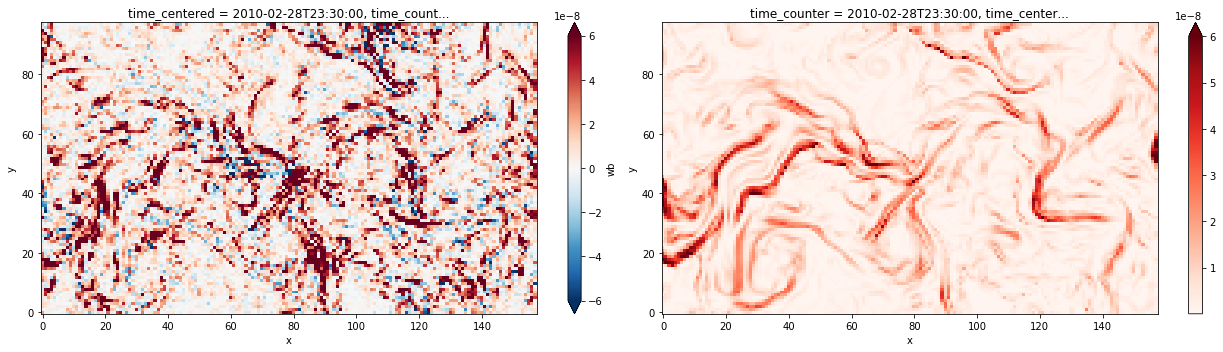

In [50]:
fig, axes = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
wsbsb_bar.sel(time_counter='2010-02-28').isel(y=slice(1,-1),
                                              x=slice(1,-1)).plot(ax=axes[0], vmax=6e-8, cmap='RdBu_r',
                                                                  rasterized=True)
(boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1),x=slice(1,-1)) 
 * Ce_lad).sel(time_counter='2010-02-28').plot(ax=axes[1], vmax=6e-8, cmap='Reds', rasterized=True)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_LAD_GulfStream_2010-02-28.pdf')

In [53]:
consts_lad_EBF = xr.DataArray(np.ones((Nt,2))*np.nan, dims=['time_counter','coeffs'],
                              coords={'time_counter':BFK_bar.time_counter.sel(time_counter=slice('2009-12-17',
                                                                                                 None)).data})
consts_lad_Bo = xr.DataArray(np.ones((Nt,2))*np.nan, dims=['time_counter','coeffs'],
                             coords={'time_counter':BFK_bar.time_counter.sel(time_counter=slice('2009-12-17',
                                                                                                None)).data})
consts_lad_tot = xr.DataArray(np.ones((Nt,3))*np.nan, dims=['time_counter','coeffs'],
                              coords={'time_counter':BFK_bar.time_counter.sel(time_counter=slice('2009-12-17',
                                                                                                 None)).data})
# cep = xr.DataArray(np.ones(Nt)*np.nan, dims=['time_counter'],
#                    coords={'time_counter':BFK_bar.time_counter.data})

for tt in wsbsb_bar.time_counter.sel(time_counter=slice('2009-12-17',None)):
    bfk = np.ma.masked_invalid((boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1), 
                                                                        x=slice(1,-1))).sel(time_counter=tt))
    wb = np.ma.masked_invalid(wsbsb_bar.isel(y=slice(1,-1), x=slice(1,-1)).sel(time_counter=tt))
    bfk_comp = np.ma.masked_array(bfk, wb.mask).compressed()
    wb_comp = np.ma.masked_array(wb, bfk.mask).compressed()
    
    bo = np.ma.masked_array(np.ma.masked_array(Bos_b.isel(y=slice(1,-1), 
                                                          x=slice(1,-1)).sel(time_counter=tt),bfk.mask),
                            wb.mask).compressed()
    ebf = np.ma.masked_array(np.ma.masked_array(EBF_bar.isel(y=slice(1,-1), 
                                                             x=slice(1,-1)).sel(time_counter=tt),bfk.mask),
                             wb.mask).compressed()
    
    
    output = minimize(cost_func, [1.,1e-2], 
                      args=(np.c_[bfk_comp.reshape((len(bfk_comp),1)), ebf.reshape((len(bfk_comp),1))], wb_comp))
    consts_lad_EBF.sel(time_counter=tt)[0] = output.x[0]
    consts_lad_EBF.sel(time_counter=tt)[1] = output.x[1]
    
    output = minimize(cost_func, [1.,1e-3], 
                      args=(np.c_[bfk_comp.reshape((len(bfk_comp),1)), bo.reshape((len(bfk_comp),1))], wb_comp))
    consts_lad_Bo.sel(time_counter=tt)[0] = output.x[0]
    consts_lad_Bo.sel(time_counter=tt)[1] = output.x[1]
    
    output = minimize(cost_func, [1.,1e-3,1e-2], 
                      args=(np.c_[bfk_comp.reshape((len(bfk_comp),1)), bo.reshape((len(bfk_comp),1)), 
                                  ebf.reshape((len(bfk_comp),1))], wb_comp))
    consts_lad_tot.sel(time_counter=tt)[0] = output.x[0]
    consts_lad_tot.sel(time_counter=tt)[1] = output.x[1]
    consts_lad_tot.sel(time_counter=tt)[2] = output.x[2]
    
consts_lad_tot

<xarray.DataArray (time_counter: 165, coeffs: 3)>
array([[ 3.49395084e-01, -7.55316443e-04, -3.48577108e-02],
       [ 4.34786652e-01, -1.19998236e-03,  5.26124302e-03],
       [ 4.95617396e-01, -2.49478440e-03,  1.25065992e-02],
       [ 4.53467235e-01, -1.51359494e-03, -9.16618877e-03],
       [ 5.26901763e-01, -6.37355419e-04, -9.70678937e-03],
       [ 4.93926138e-01, -1.46229919e-03, -1.50794095e-02],
       [ 4.72130554e-01, -1.66945234e-04, -2.25426305e-03],
       [ 4.50370772e-01, -1.11760334e-03, -7.73266726e-03],
       [ 3.74203204e-01, -4.12972135e-05, -7.50138188e-04],
       [ 4.15835070e-01,  2.82019874e-04, -5.95797463e-03],
       [ 3.70359556e-01,  1.27540761e-03,  7.89492087e-03],
       [ 4.97238853e-01,  1.99951319e-04, -1.84978713e-02],
       [ 6.51837445e-01, -8.17405172e-04, -2.70187097e-02],
       [ 5.62367800e-01, -1.21962406e-03, -9.64441884e-03],
       [ 5.65529969e-01, -7.73200714e-04, -4.42802264e-03],
       [ 6.15731252e-01,  5.62808621e-04, -8.07063703e-03],
       [ 7.44310475e-01, -2.41148287e-04, -1.77353497e-02],
       [ 6.22774876e-01, -1.16366546e-03, -2.07646605e-02],
       [ 6.09997243e-01, -8.12724409e-04, -4.85480247e-03],
       [ 6.39835597e-01, -1.38119503e-03,  2.36462161e-02],
       [ 5.76750907e-01, -5.53458361e-04, -1.82715069e-03],
       [ 4.99439951e-01, -2.07441093e-04,  3.51237479e-04],
       [ 5.41096189e-01, -5.97005920e-04,  2.80795362e-02],
       [ 5.19788684e-01, -7.38397216e-04, -1.29309825e-02],
       [ 4.23679015e-01, -1.12066040e-03,  1.87930778e-02],
       [ 5.15464575e-01,  7.74414431e-04,  7.61582029e-03],
       [ 5.64799699e-01, -1.11812394e-05,  8.23304310e-04],
       [ 5.63014809e-01, -2.87641263e-04,  1.17667885e-04],
       [ 6.31973740e-01,  1.02460961e-03, -4.46970108e-03],
       [ 5.81545886e-01,  7.90684694e-04, -2.07455076e-02],
       [ 6.25615610e-01,  1.78829146e-03, -8.70179723e-03],
       [ 6.43976462e-01, -1.96181966e-04, -1.27650414e-03],
       [ 7.35736362e-01, -1.46773635e-03, -1.28379601e-02],
       [ 7.49627150e-01,  1.77358078e-03, -1.45357163e-02],
       [ 6.06919654e-01,  5.16631301e-05, -2.31018714e-02],
       [ 5.93785368e-01, -1.15298906e-03, -1.12090395e-02],
       [ 5.63170944e-01, -5.98776473e-04, -1.70013320e-02],
       [ 6.00950596e-01, -4.11754628e-04, -4.12196015e-03],
       [ 4.63704240e-01,  3.63804272e-04,  9.87029146e-03],
       [ 4.57548536e-01, -2.46930318e-04,  1.96280384e-04],
       [ 5.45637604e-01, -6.52915640e-04, -2.37061263e-02],
       [ 7.04888409e-01, -1.05166717e-03, -1.53714849e-02],
       [ 5.37641542e-01, -2.19439537e-04, -1.53345469e-02],
       [ 5.20632909e-01, -2.63805055e-04, -1.59934269e-02],
       [ 5.29806754e-01, -1.28251357e-03, -8.25199381e-03],
       [ 6.61036612e-01, -8.63385435e-04, -8.90141023e-03],
       [ 5.31067020e-01, -6.00061809e-04, -1.30413091e-02],
       [ 5.16919116e-01, -1.48930656e-03, -1.35124301e-02],
       [ 4.99880847e-01, -4.29141199e-03, -1.08752576e-02],
       [ 6.59782619e-01, -3.05777933e-04, -3.32892528e-06],
       [ 5.05591768e-01, -2.68141299e-04, -1.27693854e-03],
       [ 4.84017376e-01, -1.55624559e-03,  1.29006530e-02],
       [ 5.97575386e-01, -9.73801422e-04, -1.35260030e-02],
       [ 6.22248326e-01, -1.00640142e-03,  2.05918305e-02],
       [ 7.17328162e-01,  9.54056865e-04,  1.80451569e-02],
       [ 6.97817664e-01, -9.35838127e-05, -2.75615118e-02],
       [ 8.92530148e-01, -5.41021207e-04, -3.26027171e-03],
       [ 7.52977649e-01, -1.42427621e-03,  3.59769514e-04],
       [ 8.97827150e-01, -2.57824049e-03,  3.31412312e-02],
       [ 7.11125946e-01, -6.30007795e-05, -3.67990635e-03],
       [ 7.41970712e-01, -4.01182774e-04, -7.63122887e-03],
       [ 7.18295469e-01,  3.48432659e-04, -2.20492020e-02],
       [ 7.34644211e-01,  1.91732185e-05, -1.74464224e-02],
       [ 8.90258976e-01, -5.49466938e-04, -2.23686005e-02],
       [ 8.78798009e-01,  5.09005429e-04, -1.78354119e-02],
       [ 7.13759038e-01,  1.79253188e-03,  2.58359

In [72]:
consts_lad_tot.to_netcdf(op.join(scratch,'GulfStream/Ce-delta-gamma_LAD_Ncoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
                                 % (5,2009,12,17,2010,5,30)), mode='w')

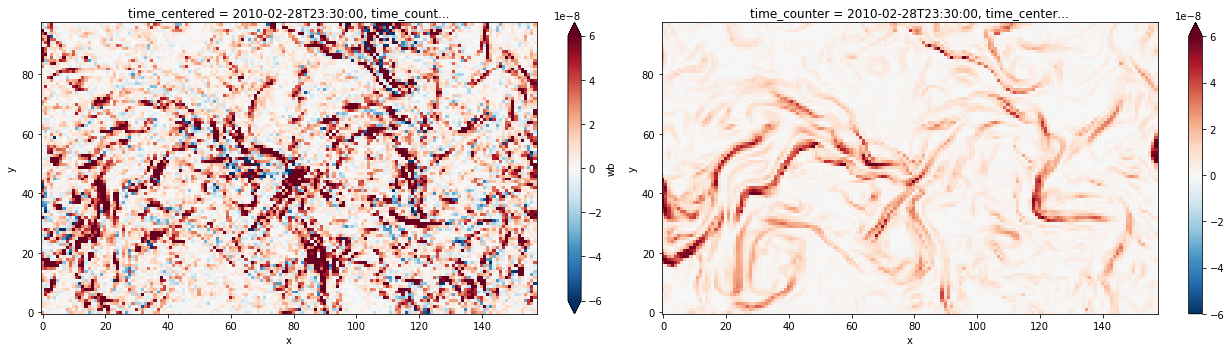

In [58]:
fig, axes = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
wsbsb_bar.sel(time_counter='2010-02-28').isel(y=slice(1,-1),
                                              x=slice(1,-1)).plot(ax=axes[0], vmax=6e-8, cmap='RdBu_r',
                                                                  rasterized=True)
(boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_tot[:,0]
 + Bos_b.isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_tot[:,1] 
 + EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_tot[:,2]
).sel(time_counter='2010-02-28').plot(ax=axes[1], vmax=6e-8, cmap='RdBu_r', rasterized=True)
plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_EBF-and-Bo_LAD_GulfStream_2010-02-28.pdf')

In [68]:
Nt,Ny,Nx = BFK_bar.sel(time_counter=slice('2009-12-17',None)).shape
consts_lad_pos = xr.DataArray(np.ones((Nt,3))*np.nan, dims=['time_counter','coeffs'],
                              coords={'time_counter':BFK_bar.time_counter.sel(time_counter=slice('2009-12-17',None)).data})


for tt in wsbsb_bar.time_counter.sel(time_counter=slice('2009-12-17',None)):
    bfk = np.ma.masked_invalid((boostm*BFK_bar.where(BFK_bar<1e-7).isel(y=slice(1,-1), 
                                                                        x=slice(1,-1))).sel(time_counter=tt))
    wb = np.ma.masked_invalid(wsbsb_bar.where(wsbsb_bar>0.).isel(y=slice(1,-1), 
                                                                 x=slice(1,-1)).sel(time_counter=tt))
    bfk_comp = np.ma.masked_array(bfk, wb.mask).compressed()
    wb_comp = np.ma.masked_array(wb, bfk.mask).compressed()
    tempC = minimize(cost_func, 1., args=(bfk_comp.reshape((len(bfk_comp),1)), wb_comp)).x[0]
    
    
    dwb = (wsbsb_bar.sel(time_counter=tt).isel(y=slice(1,-1),x=slice(1,-1)) 
           - tempC*bfk)
    dwb = np.ma.masked_invalid(dwb)
    dwb_comp = dwb.compressed()
    bo = np.ma.masked_array(Bos_b[23::24].sel(time_counter=tt).isel(y=slice(1,-1),x=slice(1,-1)),
                            dwb.mask).compressed()
    ebf = np.ma.masked_array(EBF_bar.isel(y=slice(1,-1), x=slice(1,-1)).sel(time_counter=tt),
                             dwb.mask).compressed()
    tempd = minimize(cost_func, [1e-3,1e-2], 
                     args=(np.c_[bo.reshape((len(bo),1)), ebf.reshape((len(ebf),1))], dwb_comp))
    
    
    consts_lad_pos.sel(time_counter=tt)[:] = np.array([tempC,tempd.x[0],tempd.x[1]])
    
consts_lad_pos.to_netcdf(op.join(scratch,'GulfStream/Ce-delta-gamma_pos_LAD_Ncoars%02d_%4d-%02d-%02d_%4d-%02d-%02d.nc' 
                                 % (5,2009,12,17,2010,5,30)), mode='w')

In [70]:
bfk_lad = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1)) * Ce_lad
          ).load().median(dim=['y','x'], skipna=True) 
bfk_lad_cons = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))
                * Ce_lad.mean('time_counter',skipna=True)
               ).load().median(dim=['y','x'], skipna=True) 

# pos_bfk = (boostm * BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1)) * const_pos[:,0]
#           ).load().median(dim=['y','x'],skipna=True)


net_lad = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))*consts_lad_tot[:,0]
           + Bos_b.isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_tot[:,1]
           + EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_tot[:,2]
          ).load().median(dim=['y','x'],skipna=True) 
net_lad_pos = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))*consts_lad_pos[:,0]
               + Bos_b.isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_pos[:,1]
               + EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_pos[:,2]
              ).load().median(dim=['y','x'],skipna=True) 
net_lad_EBF = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))*consts_lad_EBF[:,0]
               + EBF_bar.isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_EBF[:,1]
              ).load().median(dim=['y','x'],skipna=True)
net_lad_Bo = (boostm*BFK_bar.where(BFK_bar<1e-7).sel(y=slice(1,-1),x=slice(1,-1))*consts_lad_Bo[:,0]
              + Bos_b[23::24].isel(y=slice(1,-1),x=slice(1,-1))*consts_lad_Bo[:,1]
             ).load().median(dim=['y','x'],skipna=True)

net_lad

<xarray.DataArray (time_counter: 165)>
array([2.65071284e-09, 3.70365245e-09, 4.27768838e-09, 3.29689844e-09,
       3.79587213e-09, 3.69171835e-09, 3.66780953e-09, 3.48226530e-09,
       3.29056142e-09, 4.79038050e-09, 3.82414863e-09, 4.17594944e-09,
       4.36165225e-09, 4.70142325e-09, 5.30124353e-09, 5.29666552e-09,
       4.76001996e-09, 4.21288570e-09, 4.54008517e-09, 4.29688664e-09,
       3.34419687e-09, 3.11989160e-09, 3.64513653e-09, 3.76348633e-09,
       3.17516888e-09, 4.06068353e-09, 4.38391993e-09, 3.85774197e-09,
       4.93669203e-09, 4.64281336e-09, 4.24054831e-09, 4.82347788e-09,
       5.06930335e-09, 4.61880771e-09, 3.68833711e-09, 4.19570122e-09,
       4.23072664e-09, 4.09860341e-09, 4.07703482e-09, 3.98915316e-09,
       4.04506640e-09, 3.93853572e-09, 2.80652442e-09, 3.05739047e-09,
       3.70691566e-09, 4.54393837e-09, 4.34229559e-09, 4.79133871e-09,
       4.70300211e-09, 5.70439952e-09, 5.70134934e-09, 4.92211416e-09,
       4.48707512e-09, 5.07941393e-09, 5.39035913e-09, 4.94328406e-09,
       4.79868182e-09, 5.32482323e-09, 6.04893302e-09, 4.74494488e-09,
       5.36491513e-09, 4.91081371e-09, 4.58661503e-09, 4.53323220e-09,
       5.00255660e-09, 4.19677354e-09, 4.27097477e-09, 4.61110987e-09,
       4.86369597e-09, 3.70189216e-09, 4.14457841e-09, 4.36306073e-09,
       3.32687750e-09, 2.87400717e-09, 2.97043741e-09, 2.47349731e-09,
       2.14908116e-09, 2.32254656e-09, 2.22757253e-09, 2.33750482e-09,
       2.49683188e-09, 1.99947477e-09, 2.27214104e-09, 1.78699791e-09,
       1.91584256e-09, 1.76863318e-09, 2.08515480e-09, 2.31619392e-09,
       2.48166888e-09, 2.44196369e-09, 2.58671527e-09, 2.52475521e-09,
       2.60136414e-09, 2.02559188e-09, 1.95315445e-09, 1.45774891e-09,
       1.94752074e-09, 2.09157823e-09, 2.11237165e-09, 1.92648384e-09,
       2.09357893e-09, 2.33652493e-09, 2.39116342e-09, 2.36584171e-09,
       1.75408753e-09, 1.30764141e-09, 1.44855480e-09, 1.07313113e-09,
       1.24569019e-09, 1.05169891e-09, 1.05285590e-09, 1.28491460e-09,
       1.56257560e-09, 1.27675792e-09, 1.71127135e-09, 1.36226572e-09,
       8.28195224e-10, 1.18779801e-09, 1.03969974e-09, 1.52642415e-09,
       1.40525948e-09, 1.60874634e-09, 1.32118117e-09, 1.41450907e-09,
       1.73789181e-09, 1.90267798e-09, 1.47802420e-09, 1.64203757e-09,
       1.70432383e-09, 1.77401782e-09, 1.76281187e-09, 1.55073093e-09,
       1.24354279e-09, 1.07647207e-09, 1.20851164e-09, 1.39232485e-09,
       9.92219500e-10, 1.19412371e-09, 1.00821685e-09, 1.16417345e-09,
       1.05562966e-09, 8.25950333e-10, 1.01851638e-09, 8.39538500e-10,
       7.56320023e-10, 5.23088671e-10, 1.12897882e-09, 7.19634386e-10,
       1.08661761e-09, 8.54176968e-10, 8.70108945e-10, 1.14744427e-09,
       7.90021627e-10, 8.12345949e-10, 9.89112878e-10, 1.27213333e-09,
       8.66862668e-10, 1.20481738e-09, 9.02103483e-10, 1.05986992e-09,
       1.80784618e-09, 1.41932820e-09, 1.25761248e-09, 1.83789804e-09,
       1.30712542e-09])
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 2009-12-17T23:30:00 ... 2010-05-30T23:30:00
    time_centered  (time_counter) datetime64[ns] 2009-12-17T23:30:00 ... 2010-05-30T23:30:00
    deptht         float32 0.48045477

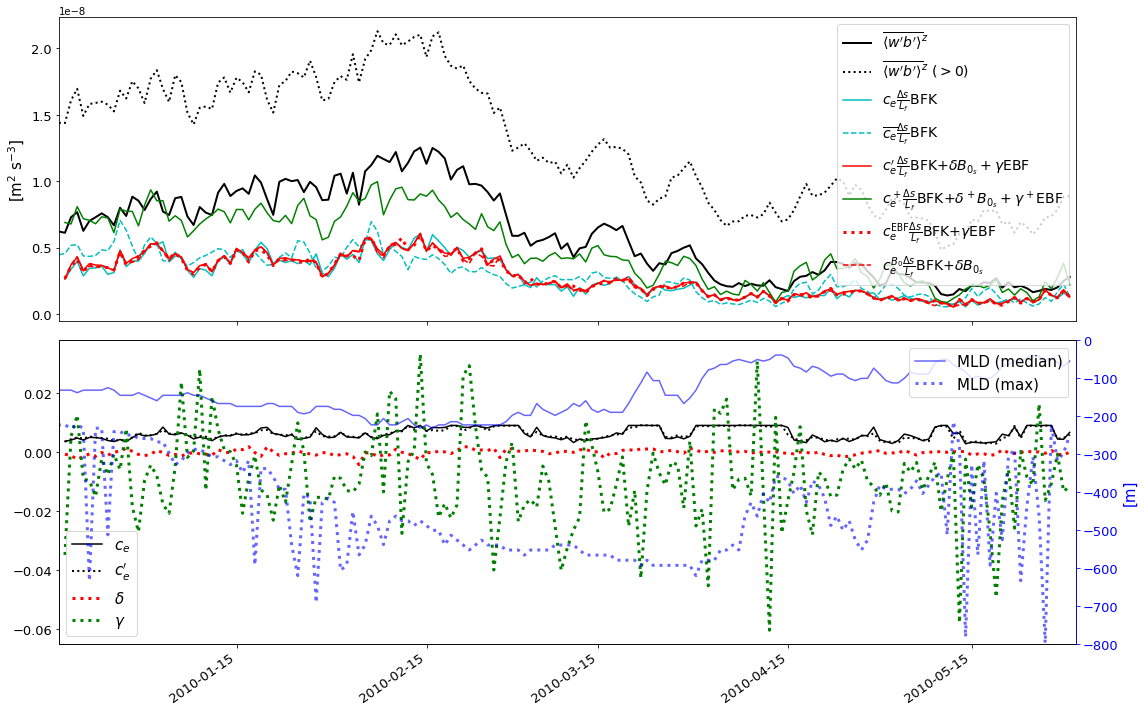

In [74]:
fig, (ax1,ax2) = plt.subplots(figsize=(16,10), nrows=2, ncols=1)
fig.set_tight_layout(True)
# ax2 = ax1.twinx()
ax3 = ax2.twinx()
# ax4 = ax1.twinx()
# ax5 = ax.twinx()
# ax6 = ax5.twinx()

# ax3.spines['left'].set_position(('axes',-0.059))
# ax4.spines['left'].set_position(('axes',-0.12))
# ax5.spines['right'].set_position(('axes',1.068))
# ax6.spines['right'].set_position(('axes',1.138))


ax1.plot(wsbs.time_counter, wsbs, color='k', lw=2, label=r"$\overline{\langle w'b'\rangle}^z$")
# wsbs_abs.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax1, color='k', ls='--', lw=2, 
#                                                      label=r"$|\overline{\langle w'b'\rangle}^z|$")
# ax1.plot(wsbs_pos.time_counter, wsbs_pos, color='k', ls=':', lw=2, label=r"$\overline{\langle w'b'\rangle}^z\ (>0)$")
ax1.plot(bfk_lad.time_counter.data, bfk_lad.data, color='c', ls='-', label=r"$c_e\frac{\Delta s}{L_f}$BFK")
ax1.plot(bfk_lad_cons.time_counter.data, bfk_lad_cons.data, color='c', ls='--', label=r"$\overline{c_e}\frac{\Delta s}{L_f}$BFK")
# ax1.plot(pos_bfk.time_counter.data, pos_bfk.data, color='g', ls='--', label=r"$c_e^+\frac{\Delta s}{L_f}$BFK")
# abs_bfk.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax1, color='r', ls='--', lw=2,
#                                                         label=r"$c_e'$BFK")
# ax1.plot(pos_bfk.time_counter.data, pos_bfk.data, color='c', ls=':', lw=3, label=r"$c_e^+$BFK")
# bfk.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax1, color='c', ls=':', lw=2,
#                 label=r"$\overline{c_e'}$BFK")
ax1.plot(net_lad.time_counter.data, net_lad.data, color='r', ls='-', 
         label=r"$c_e'\frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s} + \gamma$EBF")
ax1.plot(net_lad_pos.time_counter.data, net_lad_pos.data, color='g', ls='-', 
         label=r"$c_e^+\frac{\Delta s}{L_f}$BFK$+ \delta^+ B_{0_s} + \gamma^+$EBF")
ax1.plot(net_lad_EBF.time_counter.data, net_lad_EBF.data, color='r', ls=':', lw=3, 
         label=r"$c_e^{\tt EBF}\frac{\Delta s}{L_f}$BFK$ + \gamma$EBF")
ax1.plot(net_lad_Bo.time_counter.data, net_lad_Bo.data, color='r', ls='--',
         label=r"$c_e^{B_0}\frac{\Delta s}{L_f}$BFK$+ \delta B_{0_s}$")
# (1*net_cons2).sel(time_counter=slice('2009-11-07',None)).plot(ax=ax1, color='g', ls='-',
#                                                         label=r"$\overline{c_e'}$BFK $+\delta B_{0_s}$")
# Bos.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax3, color='grey', ls='-',
#                                                     label=r"$B_0$ (submeso)")

(-mld).plot(ax=ax3, color='b', ls='-', alpha=.6, label=r"MLD (median)")
(-mld_max).plot(ax=ax3, color='b', ls=':', alpha=.6, lw=3, label=r"MLD (max)")

(Ce_lad*1e-2).plot(ax=ax2, color='k', ls='-', label=r"$c_e$")
# consts[:,1].plot(ax=ax2, color='g', ls='-', label=r"$\delta$")
(consts_lad_tot[:,0]*1e-2).plot(ax=ax2, color='k', ls=':', lw=2, label=r"$c_e'$")
consts_lad_tot[:,1].plot(ax=ax2, color='r', ls=':', lw=3, label=r"$\delta$")
consts_lad_tot[:,2].plot(ax=ax2, color='g', ls=':', lw=3, label=r"$\gamma$")
# Bos.sel(time_counter=slice('2009-11-07',None)).plot(ax=ax2, color='g', ls='--',
#                                                     label=r"$B_0$ (submeso)")


# ax2.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=15, c='g')
# (bfk).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax5, color='r', ls='-')
# (0.*wsSs).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax4, color='g', ls='--', lw=1)
# (0.*sflx).plot(ax=ax6, color='g', ls='--', lw=1)
# im6, = (.02*tflx.roll(time_counter=-1)[:-1]).plot(ax=ax5, color='b', lw=2)
# (sflx).plot(ax=ax6, color='g')


# ax1.set_ylabel(r"$\overline{\langle w'b'\rangle}^z$ [m$^2$ s$^{-3}$]", fontsize=16)
ax1.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=15)
ax3.set_ylabel(r"[m]", fontsize=15, color='b')
# ax3.set_ylabel(r"$\overline{\langle w'\theta'\rangle}^z$ $(\times 10^{-5})$ [m $^\circ$C s$^{-1}$]", fontsize=16, c='b')
# ax4.set_ylabel(r"$\overline{\langle w's'\rangle}^z$ $(\times 10^{-5})$ [m (g/kg) s$^{-1}$]", fontsize=16, c='g')
# ax2.set_ylabel(r"$\frac{H_{\tt ML}^2|\overline{\nabla_{\tt H}\langle b\rangle}^z|^2}{f} \overline{\mu}^z$ "
#                + r"$(2\times 10^{-3})$", 
#                fontsize=16, c='r')
# ax6.set_ylabel(r"$\frac{g\alpha\langle Q\rangle }{\rho_0 c_P}$ [m$^2$ s$^{-3}$]", fontsize=16, c='b')
# ax6.set_ylabel(r"$\langle\dot{S}\rangle H_{\tt ML}$ [kg m$^{-1}$ s$^{-1}$]", fontsize=16, c='g')
ax1.set_xlabel(r"")
ax2.set_xlabel(r"")
ax2.set_ylabel(r"")
# ax3.set_ylabel(r"MLD")
ax1.set_title(r"")
ax2.set_title(r"")
ax3.set_title(r"")
# ax5.set_xlabel(r"")


ax1.set_xlim(['2009-12-17','2010-06-01'])
ax1.set_xticks(['2010-01-15','2010-02-15','2010-03-15','2010-04-15','2010-05-15'])
ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=13)
ax2.set_xlim(['2009-12-17','2010-06-01'])
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xticks(['2010-01-15','2010-02-15','2010-03-15','2010-04-15','2010-05-15'])
ax2.set_xticklabels(['2010-01-15','2010-02-15','2010-03-15','2010-04-15','2010-05-15'],
                    fontsize=13, rotation=35)
ax3.set_ylim([-800,0])
# ax1.set_xticklabels([])
# ax.tick_params(axis='x', labelsize=13, labelrotation=40)
# ax5.set_xlim(['2010-01-01','2010-05-07'])
# ax.tick_params(axis='y', labelsize=13)
# ax5.tick_params(axis='x', labelsize=13, labelrotation=40)
ax2.spines['left'].set_color('k')
ax2.tick_params(axis='y', colors='k', labelsize=13)
# ax5.spines['left'].set_color('r')
# ax5.tick_params(axis='y', colors='r', labelsize=13)
# ax6.spines['right'].set_color('b')
# ax6.tick_params(axis='y', colors='b', labelsize=13)
ax3.spines['right'].set_color('b')
ax3.tick_params(axis='y', colors='b', labelsize=13)
# ax4.spines['left'].set_color('g')
# ax4.tick_params(axis='y', colors='g', labelsize=13)
# ax5.set_ylim([-27,0])

# ax3.yaxis.set_label_position('left')
# ax3.yaxis.set_ticks_position('left')
# ax4.yaxis.set_label_position('left')
# ax4.yaxis.set_ticks_position('left')

ax1.legend(loc='upper right', fontsize=14)
ax2.legend(loc='lower left', fontsize=15)
ax3.legend(loc='upper right', fontsize=15)

plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_EBF-and-Bo_LAD_GulfStream_2009-12-17_2010-05-30.pdf')

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


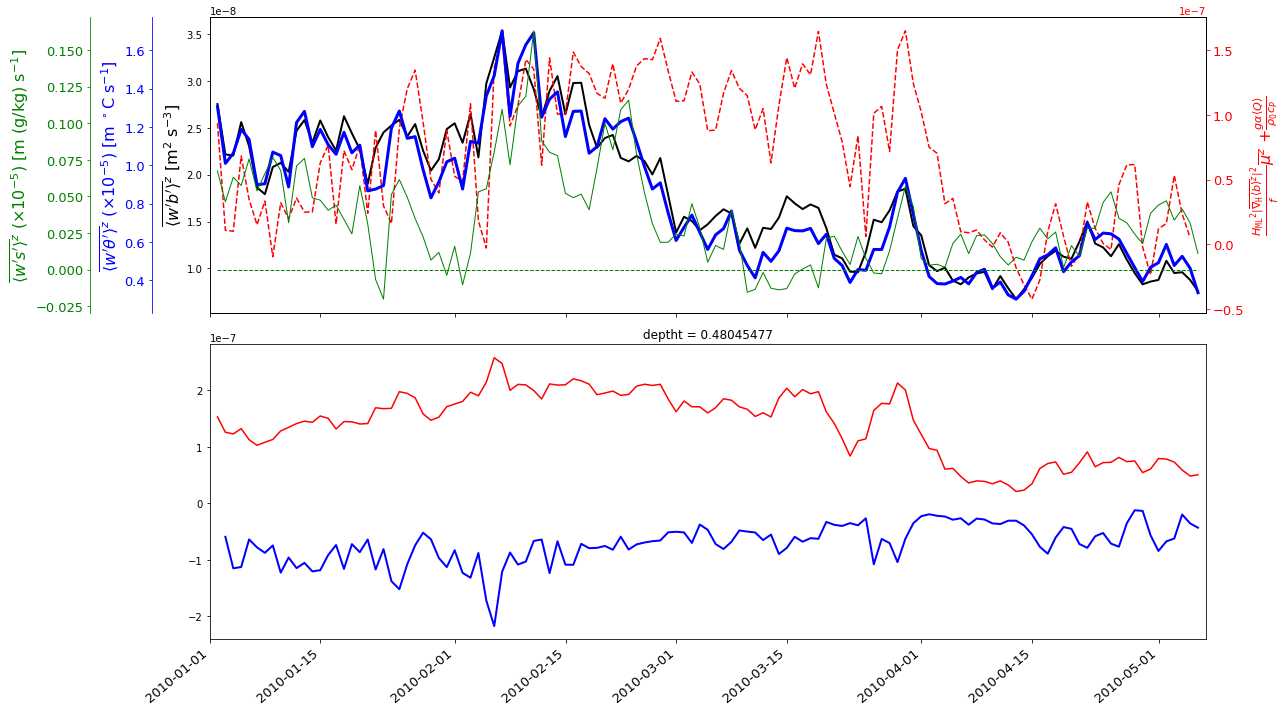

In [19]:
fig, (ax1,ax5) = plt.subplots(figsize=(18,10), nrows=2, ncols=1)
fig.set_tight_layout(True)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
# ax5 = ax.twinx()
# ax6 = ax5.twinx()

ax3.spines['left'].set_position(('axes',-0.058))
ax4.spines['left'].set_position(('axes',-0.12))
# ax5.spines['right'].set_position(('axes',1.068))
# ax6.spines['right'].set_position(('axes',1.138))


wsbs.sel(time_counter=slice('2010-01-01',None)).plot(ax=ax1, color='k', lw=2)
(wsTs*1e5).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax3, color='b', lw=3)
(wsSs*1e5).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax4, color='g', lw=1)
# (3*grav*(alpha*wsTs+beta*wsSs)).plot(ax=ax, color='k', ls='--', lw=2)
# (3*grav*alpha*wsTs).plot(ax=ax, color='g', lw=2)
# (3*grav*beta*wsSs).plot(ax=ax, color='b', lw=2)
(bfk[:-1] + .02*tflx.roll(time_counter=-1).data[:-1]).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax2, color='r', ls='--')
(bfk).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax5, color='r', ls='-')
(0.*wsSs).sel(time_counter=slice('2010-01-01',None)).plot(ax=ax4, color='g', ls='--', lw=1)
# (0.*sflx).plot(ax=ax6, color='g', ls='--', lw=1)
im6, = (.02*tflx.roll(time_counter=-1)[:-1]).plot(ax=ax5, color='b', lw=2)
# (sflx).plot(ax=ax6, color='g')


ax1.set_ylabel(r"$\overline{\langle w'b'\rangle}^z$ [m$^2$ s$^{-3}$]", fontsize=16)
ax3.set_ylabel(r"$\overline{\langle w'\theta'\rangle}^z$ $(\times 10^{-5})$ [m $^\circ$C s$^{-1}$]", fontsize=16, c='b')
ax4.set_ylabel(r"$\overline{\langle w's'\rangle}^z$ $(\times 10^{-5})$ [m (g/kg) s$^{-1}$]", fontsize=16, c='g')
ax2.set_ylabel(r"$\frac{{H_{\tt ML}}^2|\overline{\nabla_{\tt H}\langle b\rangle}^z|^2}{f} \overline{\mu}^z$ "
               + r"$+ \frac{g\alpha\langle Q\rangle }{\rho_0 c_P}$", 
               fontsize=16, c='r')
# ax6.set_ylabel(r"$\frac{g\alpha\langle Q\rangle }{\rho_0 c_P}$ [m$^2$ s$^{-3}$]", fontsize=16, c='b')
# ax6.set_ylabel(r"$\langle\dot{S}\rangle H_{\tt ML}$ [kg m$^{-1}$ s$^{-1}$]", fontsize=16, c='g')
ax1.set_xlabel(r"")
ax5.set_xlabel(r"")


ax1.set_xlim(['2010-01-01','2010-05-07'])
# ax.tick_params(axis='y', labelsize=13)
ax1.set_xticklabels([])
# ax.tick_params(axis='x', labelsize=13, labelrotation=40)
ax5.set_xlim(['2010-01-01','2010-05-07'])
# ax.tick_params(axis='y', labelsize=13)
ax5.tick_params(axis='x', labelsize=13, labelrotation=40)
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red', labelsize=13)
# ax5.spines['left'].set_color('r')
# ax5.tick_params(axis='y', colors='r', labelsize=13)
# ax6.spines['right'].set_color('b')
# ax6.tick_params(axis='y', colors='b', labelsize=13)
ax3.spines['left'].set_color('b')
ax3.tick_params(axis='y', colors='b', labelsize=13)
ax4.spines['left'].set_color('g')
ax4.tick_params(axis='y', colors='g', labelsize=13)
# ax5.set_ylim([-27,0])

ax3.yaxis.set_label_position('left')
ax3.yaxis.set_ticks_position('left')
ax4.yaxis.set_label_position('left')
ax4.yaxis.set_ticks_position('left')

# plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/wsbs_GulfStream_2010-01-01_05-05.pdf')

(6e-07, 5e-06)

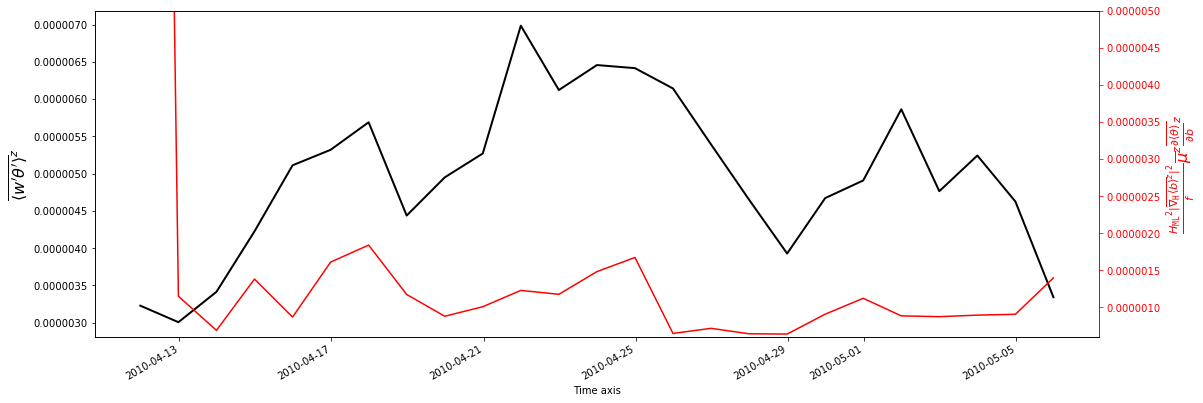

In [9]:
fig, ax = plt.subplots(figsize=(18,6))
ax2 = ax.twinx()
wsTs.sel(time_counter=slice('2010-04-11','2010-05-06')).plot(ax=ax, color='k', lw=2)
# (3*grav*(alpha*wsTs+beta*wsSs)).plot(ax=ax, color='k', ls='--', lw=2)
# (3*grav*alpha*wsTs).plot(ax=ax, color='g', lw=2)
# (3*grav*beta*wsSs).plot(ax=ax, color='b', lw=2)
(omdt).plot(ax=ax2, color='r')
ax.set_ylabel(r"$\overline{\langle w'\theta'\rangle}^z$", fontsize=16)
ax2.set_ylabel(r"$\frac{{H_{\tt ML}}^2|\overline{\nabla_{\tt H}\langle b\rangle}^z|^2}{f} \overline{\mu}^z$"
               + r"$\overline{\frac{\partial \langle\theta\rangle}{\partial b}}^z$", 
               fontsize=16, c='r')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
# ax.set_ylim(6e-7,6e-6)
ax2.set_ylim(6e-7,5e-6)

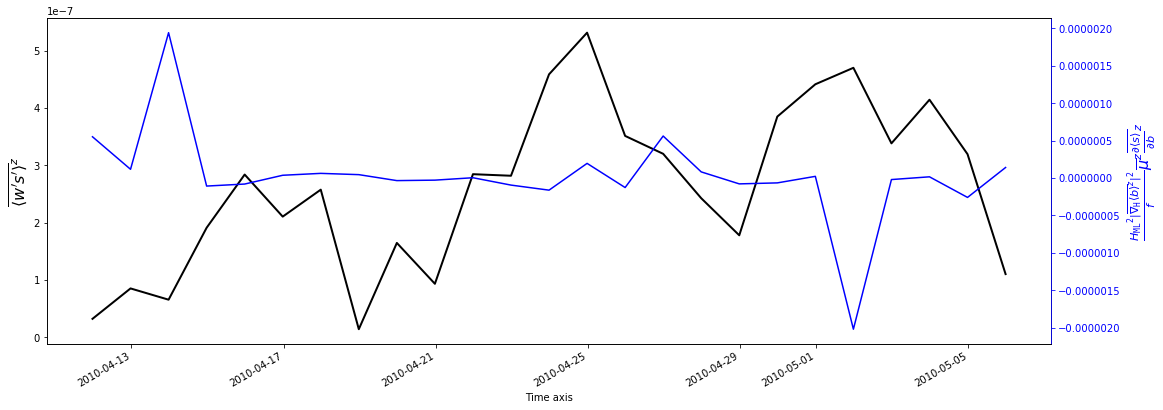

In [10]:
fig, ax = plt.subplots(figsize=(18,6))
ax2 = ax.twinx()
wsSs.sel(time_counter=slice('2010-04-11','2010-05-06')).plot(ax=ax, color='k', lw=2)
# (3*grav*(alpha*wsTs+beta*wsSs)).plot(ax=ax, color='k', ls='--', lw=2)
# (3*grav*alpha*wsTs).plot(ax=ax, color='g', lw=2)
# (3*grav*beta*wsSs).plot(ax=ax, color='b', lw=2)
(omds).plot(ax=ax2, color='b')
ax.set_ylabel(r"$\overline{\langle w's'\rangle}^z$", fontsize=16)
ax2.set_ylabel(r"$\frac{{H_{\tt ML}}^2|\overline{\nabla_{\tt H}\langle b\rangle}^z|^2}{f} \overline{\mu}^z$"
               + r"$\overline{\frac{\partial \langle s\rangle}{\partial b}}^z$", 
               fontsize=16, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
# ax.set_ylim(-2e-7,2e-7)
# ax2.set_ylim(-2e-7,2e-7)

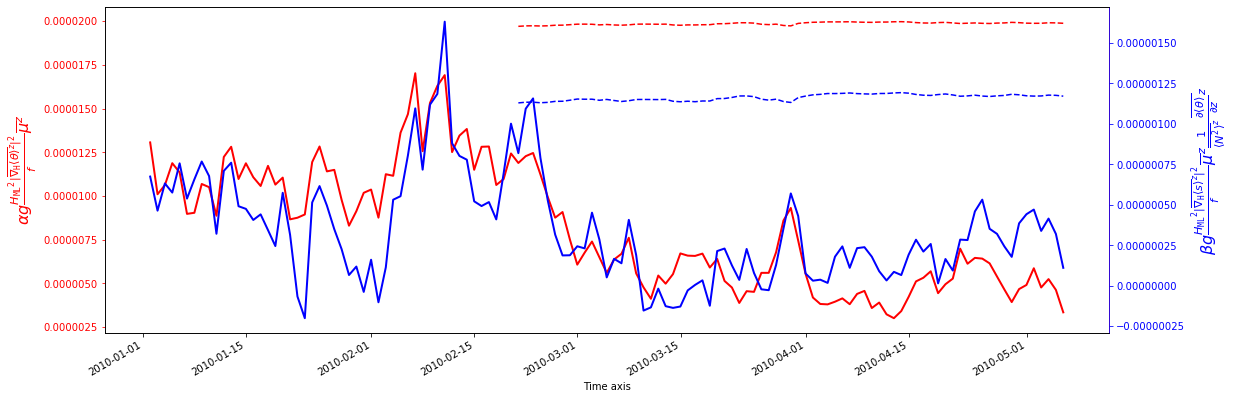

In [27]:
grav= 9.81

fig, ax = plt.subplots(figsize=(18,6))
ax2 = ax.twinx()

wsTs.plot(ax=ax, color='r', lw=2)
(-.2*alpha*bfkt + 2e-5).plot(ax=ax, color='r', ls='--')
wsSs.plot(ax=ax2, color='b', lw=2)
(-.01*beta*bfks + 1.2e-6).plot(ax=ax2, color='b', ls='--')

ax.set_ylabel(r"$\alpha g \frac{{H_{\tt ML}}^2|\overline{\nabla_{\tt H}\langle \theta\rangle}^z|^2}{f} \overline{\mu}^z$", 
              fontsize=16, c='r')
ax2.set_ylabel(r"$\beta g \frac{{H_{\tt ML}}^2|\overline{\nabla_{\tt H}\langle s\rangle}^z|^2}{f} \overline{\mu}^z$", 
               fontsize=16, c='b')
ax.spines['right'].set_color('red')
ax.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('blue')
ax2.tick_params(axis='y', colors='blue')
# ax.set_xlim(['',''])